In [1]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

In [2]:
# Импорт библиотек для машинного обучения и обработки текста
import pandas as pd
import numpy as np
import random

# Импорт sklearn для классических алгоритмов ML
from sklearn.model_selection import train_test_split, StratifiedKFold  # разделение данных и кросс-валидация
from sklearn.dummy import DummyClassifier  # наивный классификатор для бейслайна
from sklearn.compose import ColumnTransformer  # трансформация разных столбцов по-разному
from sklearn.pipeline import Pipeline  # создание пайплайнов обработки
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer  # векторизация текста
from sklearn.linear_model import LogisticRegression  # логистическая регрессия
from sklearn.tree import DecisionTreeClassifier  # дерево решений
from sklearn.ensemble import RandomForestClassifier  # случайный лес
from sklearn.base import clone  # клонирование моделей
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier  # градиентный бустинг

# Пользовательские модули
from helper import *  # вспомогательные функции
from plots import *   # функции визуализации
from nlp import *     # функции обработки естественного языка
from transformers import *  # функции для работы с трансформерами

In [3]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости
# Критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random

In [4]:
# Загружаем предобработанные данные
df = pd.read_csv('data/data.csv')

## 5. Препроцессинг данных

**Цель:** Подготовить данные для обучения моделей классического машинного обучения.
Включает очистку данных, токенизацию и создание признаков.

### 5.1 Общие преобразования

**Логика:** Приводим данные к стандартному формату для машинного обучения:
- Удаляем ненужные столбцы
- Очищаем от неинформативных записей  
- Токенизируем тексты для дальнейшей векторизации

In [5]:
df.head()

Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...

In [6]:
# Создаем копию данных для предобработки
df_preprocessed = df.copy()

# Удаляем неинформативные записи с описанием "Unknown"
df_preprocessed = df_preprocessed[df_preprocessed['Description'] != 'Unknown'] 
# Токенизируем тексты
# Это необходимо для дальнейшей векторизации текстов
df_preprocessed['Title'] = df_preprocessed['Title'].apply(tokenize_words)
df_preprocessed['Description'] = df_preprocessed['Description'].apply(tokenize_words)

In [7]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X, y = divide_data(df_preprocessed, 'Class Index')

## 6. Построение baseline

**Цель:** Создать базовые модели для сравнения с более сложными подходами.
Baseline показывает минимальный уровень качества, которого нужно достичь или превзойти.

In [8]:
# Определяем набор baseline моделей для сравнения:
models = [
    ('DummyClassifier', DummyClassifier(random_state=SEED, strategy='most_frequent')),  # наивный классификатор
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=2000, solver='lbfgs')),  # линейная модель
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4, min_samples_leaf=5,)),  # дерево решений
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, n_estimators=200, max_depth=20, min_samples_leaf=2, max_features="sqrt", n_jobs=-1)),  # случайный лес
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, verbose=-1, n_estimators=500, learning_rate=0.1, num_leaves=63, subsample=0.8,colsample_bytree=0.8))  # градиентный бустинг
]

In [9]:
# Настраиваем стратифицированную кросс-валидацию с 5 фолдами
# StratifiedKFold гарантирует, что в каждом фолде будет примерно одинаковое соотношение классов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### 6.1. CountVectorizer

**Логика:** CountVectorizer создает матрицу частот слов (bag of words).
Каждая ячейка содержит количество вхождений конкретного слова в документ.
Это простой, но эффективный способ представления текста для классических ML алгоритмов.

#### 6.1.1 Без очистки токенов

**Цель:** Проверить базовое качество с исходными токенами.
Это отправная точка для сравнения с очищенными версиями.

In [10]:
# Создаем пайплайн для векторизации текстов
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            # Векторизация заголовков: analyzer=lambda x: x означает, что вход уже токенизирован
            ('title_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, max_features=50000, dtype=np.float32), 'Title'),
            # Векторизация описаний: min_df=50 исключает слова, встречающиеся менее 50 раз
            ('description_vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=50, max_features=100000, dtype=np.float32), 'Description'),
        ],
        remainder='drop', 
        verbose_feature_names_out=True  # для отладки имен признаков
    )),
])

In [11]:
df_preprocessed.head()

Class Index                                              Title  \
0            3  [wall, st, bears, claw, back, into, the, black...   
1            3  [carlyle, looks, toward, commercial, aerospace...   
2            3  [oil, and, economy, cloud, stocks, outlook, re...   
3            3  [iraq, halts, oil, exports, from, main, southe...   
4            3  [oil, prices, soar, to, all, time, record, pos...   

                                         Description  
0  [reuters, short, sellers, wall, street, s, dwi...  
1  [reuters, private, investment, firm, carlyle, ...  
2  [reuters, soaring, crude, prices, plus, worrie...  
3  [reuters, authorities, have, halted, oil, expo...  
4  [afp, tearaway, world, oil, prices, toppling, ...

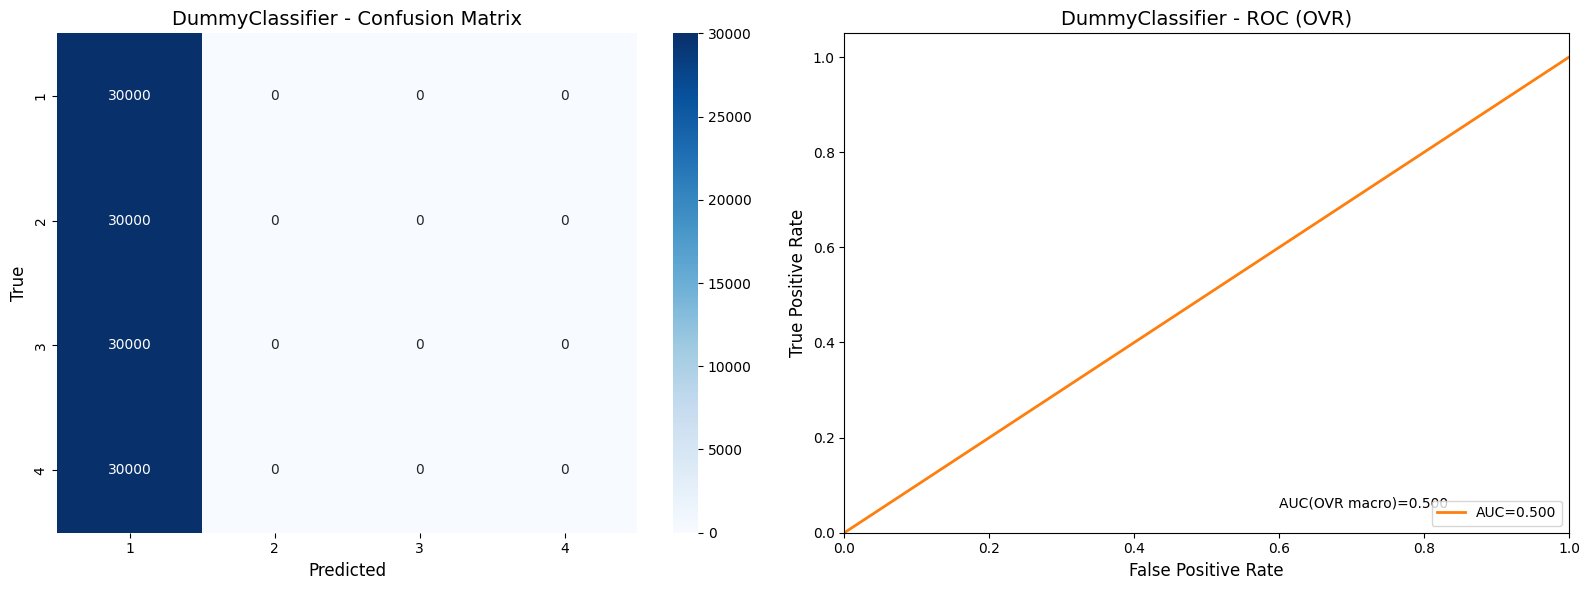

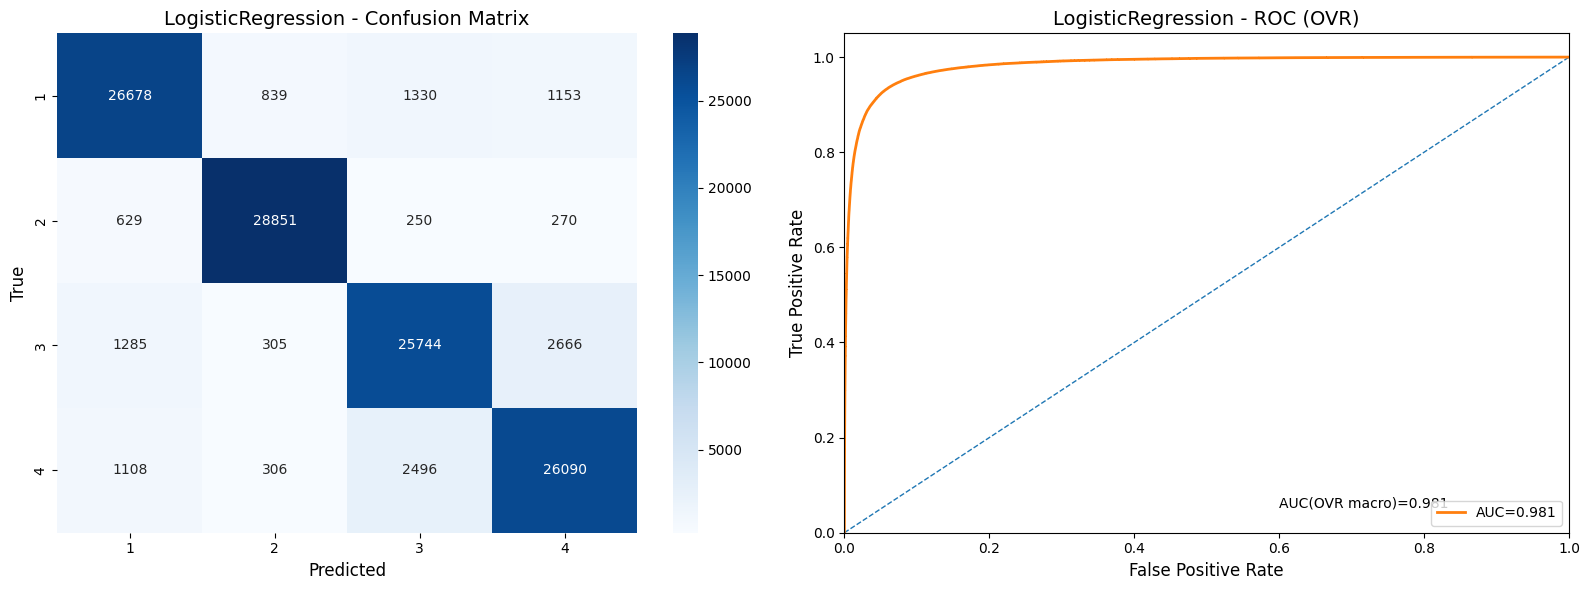

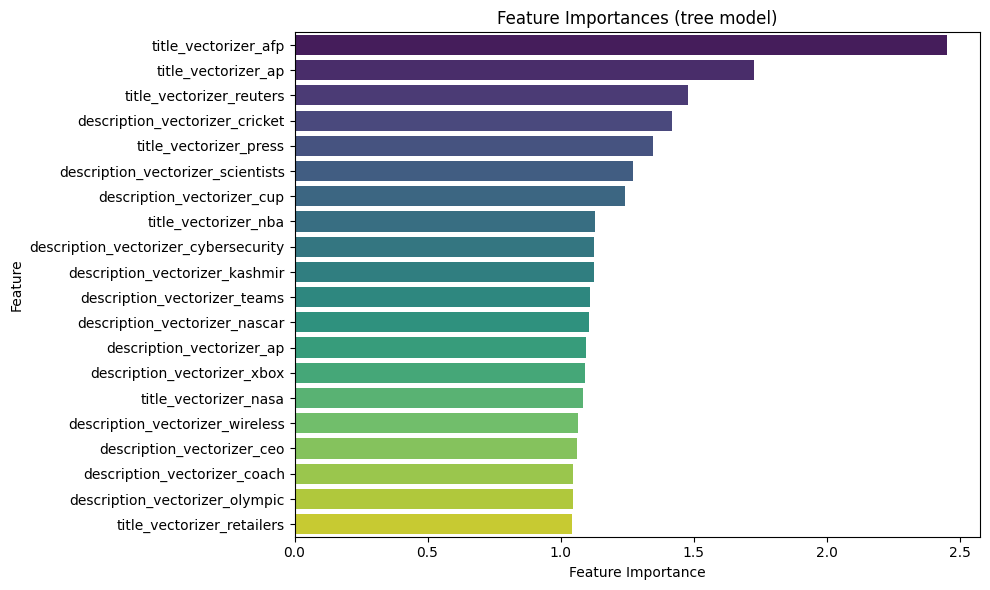

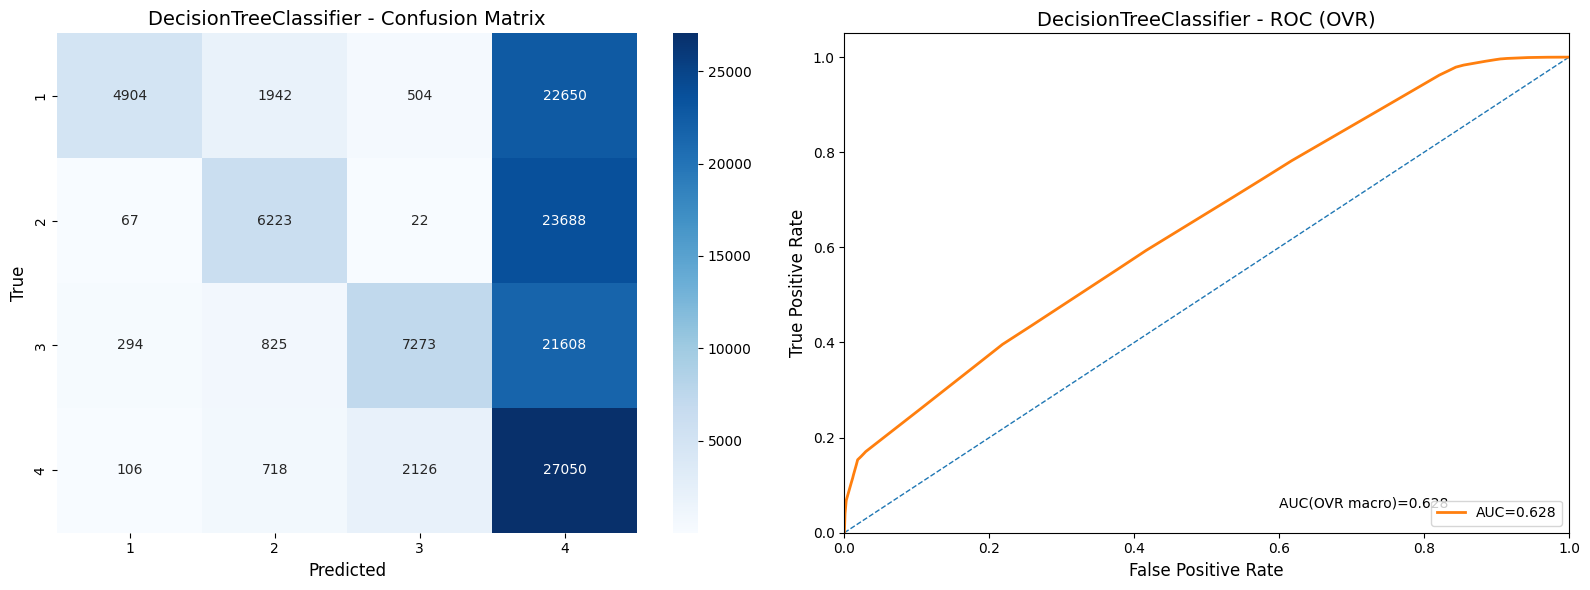

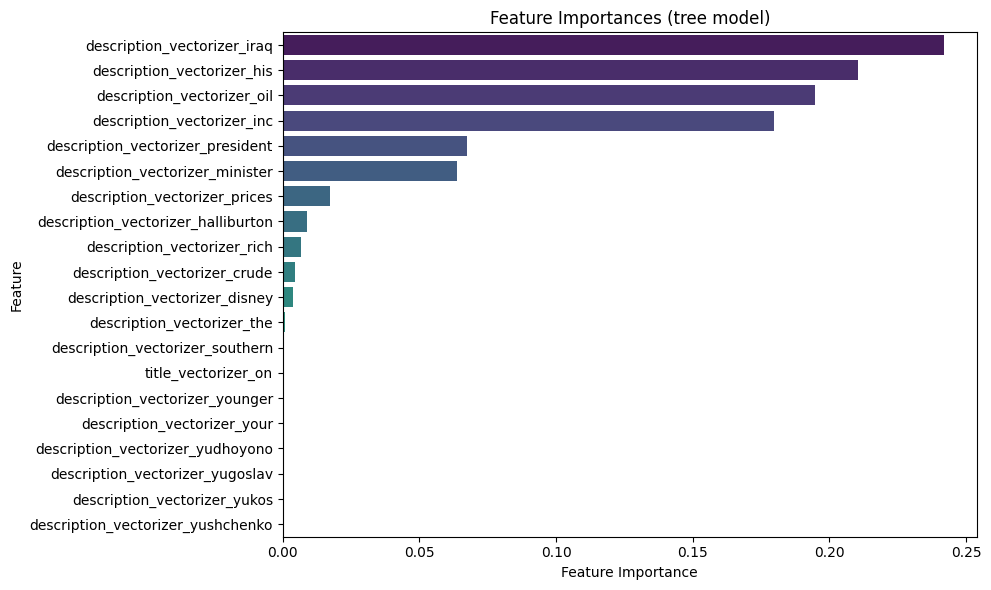

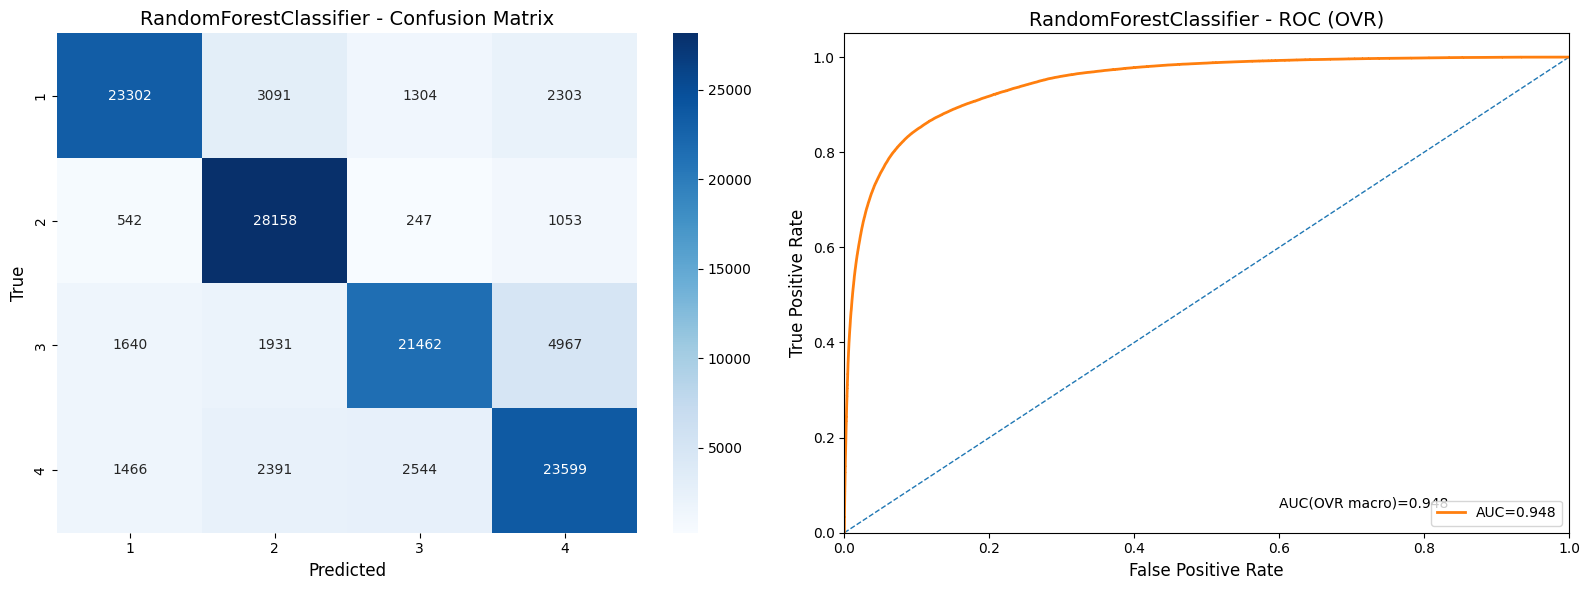

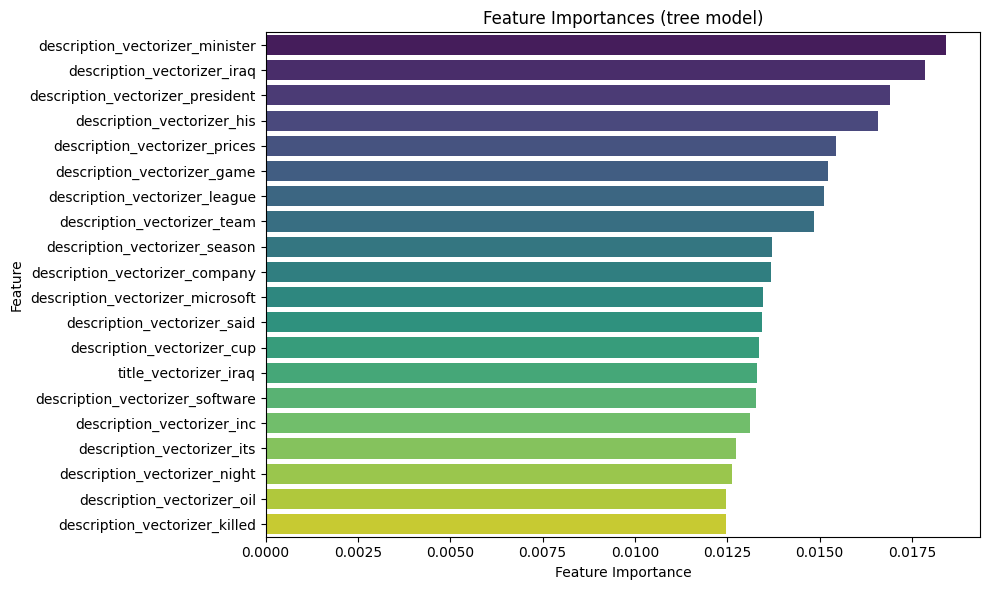

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:26

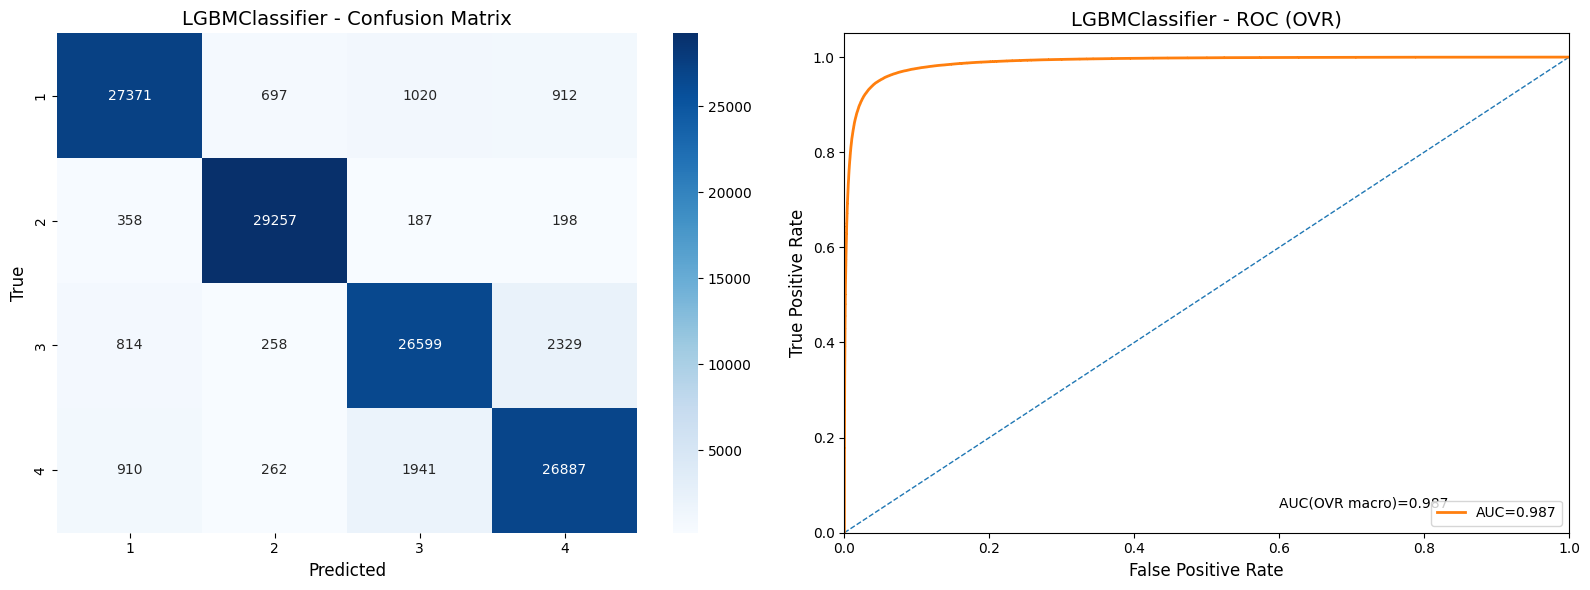

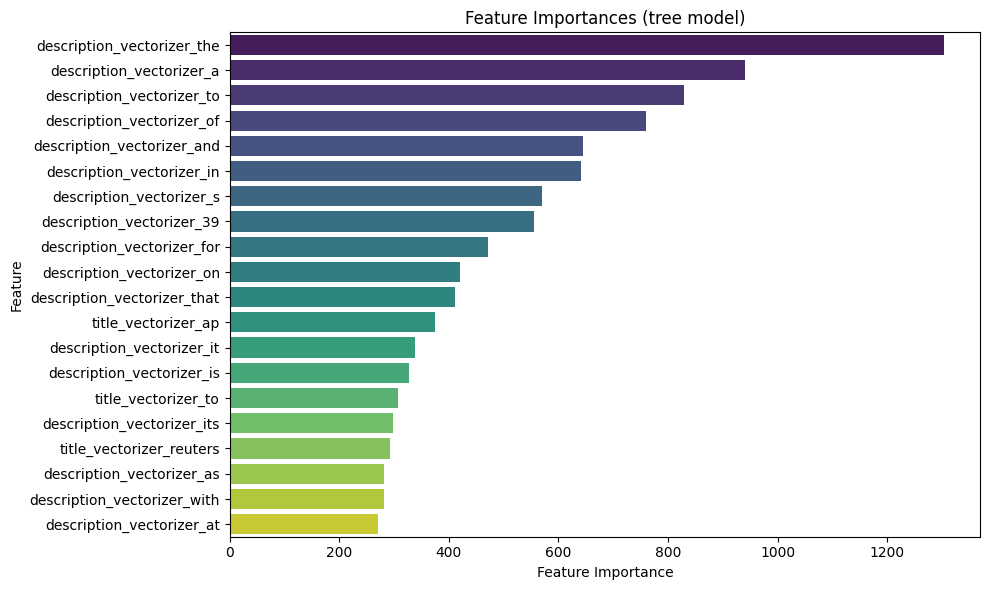

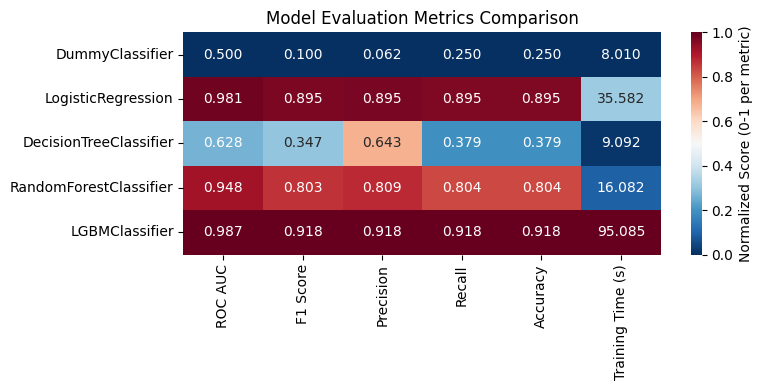

In [12]:
# Обучаем все baseline модели с кросс-валидацией
# Функция автоматически обучает каждую модель, оценивает метрики и строит графики важности признаков
count_vectorizer_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

**Для метрик использовал Macro усреднение**

**Анализ важности признаков:**

По графикам feature importance видно, что модель в первую очередь опирается на два типа токенов:

Маркерные слова источника/агентства

- title_vectorizer_reuters, title_vectorizer_ap, title_vectorizer_afp. 
Это ярлыки новостных агентств (слова, которые указывают на источник новости, а не на её смысл). Они часто встречаются в заголовках и дают модели очень сильный сигнал.

- Тематические токены, характерные для классов
Спорт: cricket, nba, teams, nascar, cup, olympic
Политика/мир: kashmir, iraq, president, minister
Бизнес/энергетика: oil, prices, inc, company, ceo
Наука/тех: cybersecurity, software, wireless, xbox, nasa

Видно на importance у бустинга, что в топ попадают частотные слова вроде the, a, to, of, and, in. 

**Вывод:** 
- Модель реально учится на содержательных “тематических” словах, что хорошо.
- Но агентские маркеры (reuters, ap, afp) — это потенциальный ярлык: модель может частично классифицировать не по смыслу новости, а по формату/источнику. Для честной семантической классификации имеет смысл проверить качество после удаления/нормализации таких токенов (например, вырезать reuters|ap|afp из заголовков).
- Также разумный следующий шаг — попробовать стоп-слова и TF-IDF

#### 6.1.2 Удалим стоп-слова

**Логика:** Стоп-слова (артикли, предлоги, союзы) обычно не несут смысловой нагрузки.
Их удаление может улучшить качество модели и ускорить обучение.

In [13]:
# Создаем копию данных для экспериментов с очисткой
X_cleaned_tokens = X.copy()

# Удаляем стоп-слова из токенов
for col in ['Description', 'Title']:
    X_cleaned_tokens[col] = X_cleaned_tokens[col].apply(
        lambda tokens: filter_tokens(
            tokens,
            remove_stopwords=True,
            to_lower=True
        )
    )


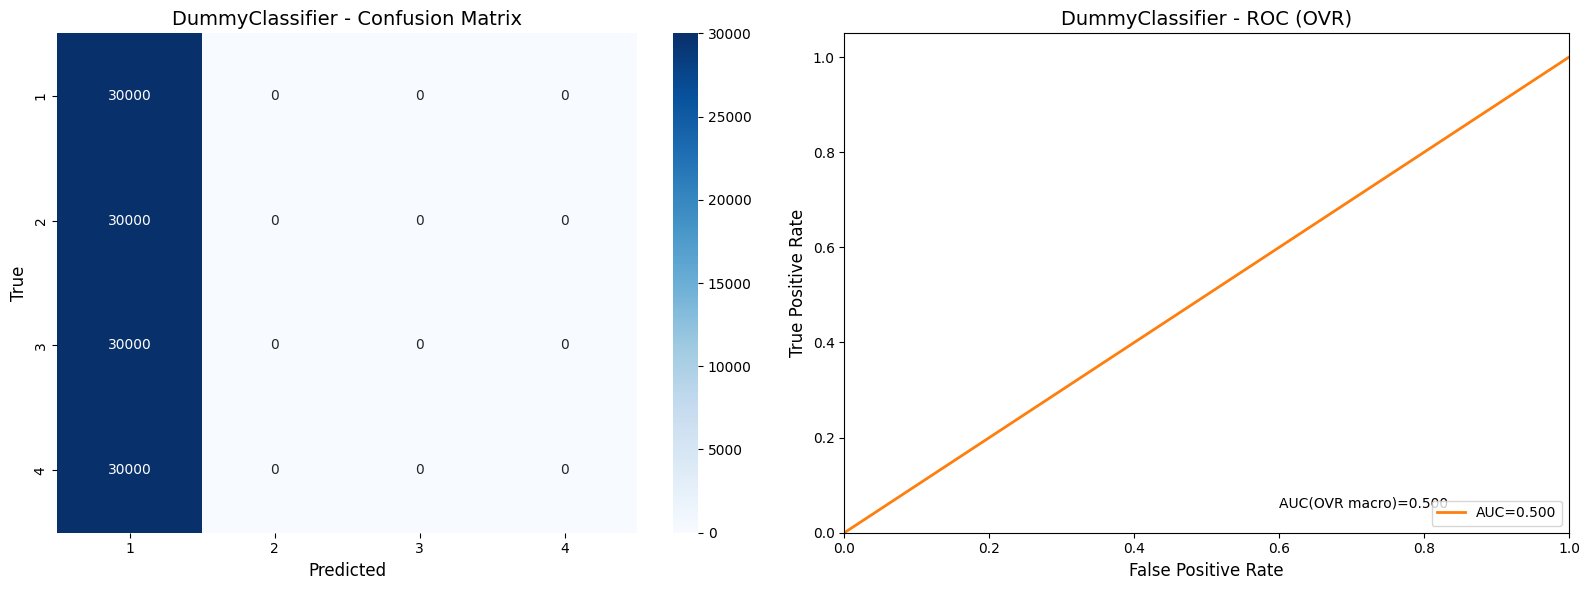

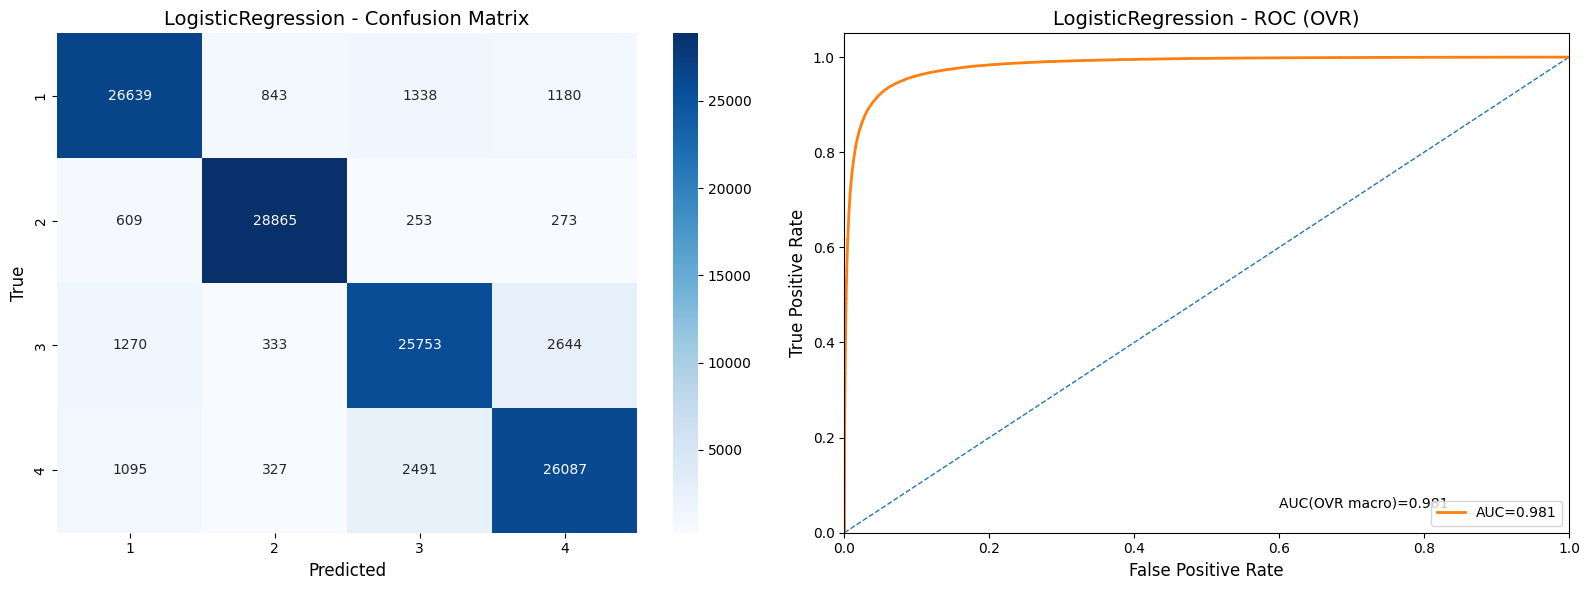

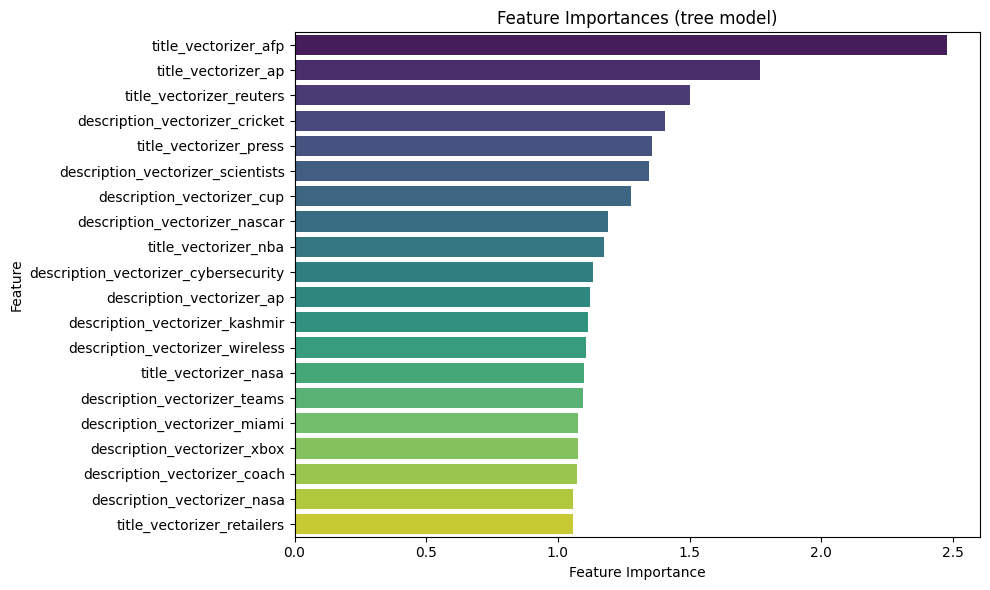

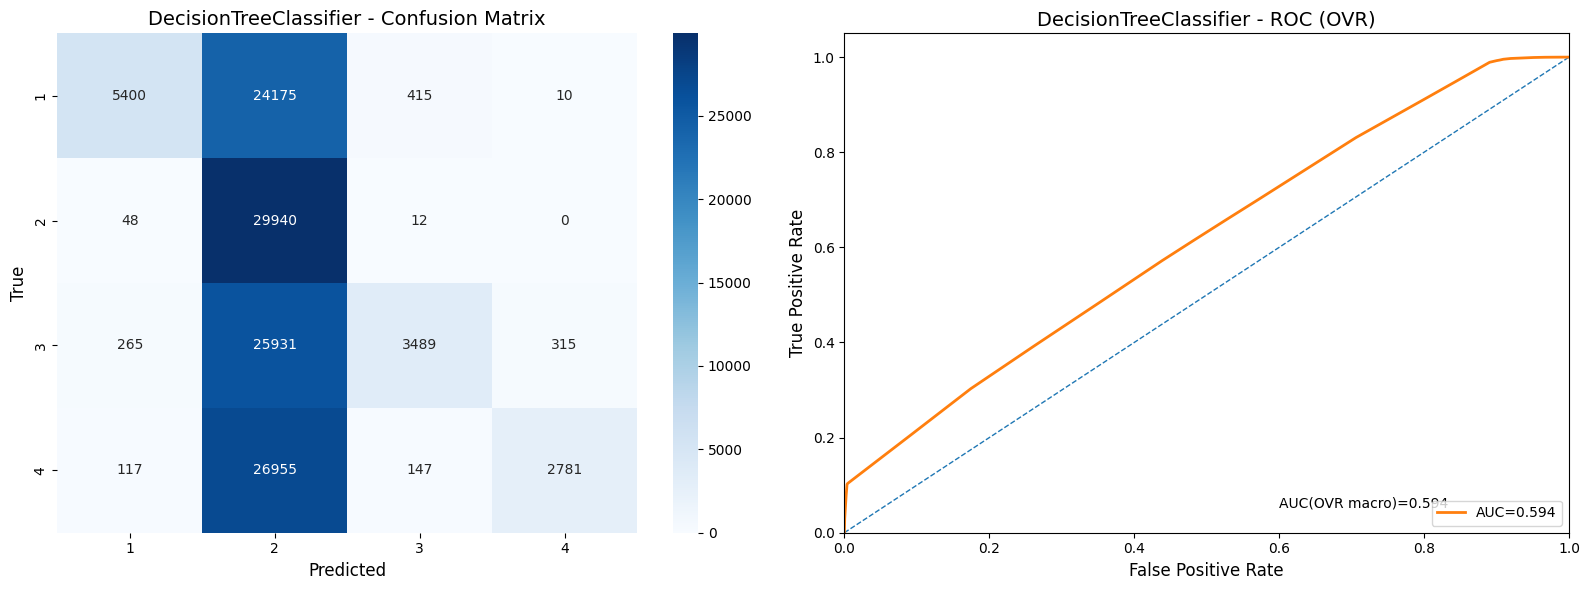

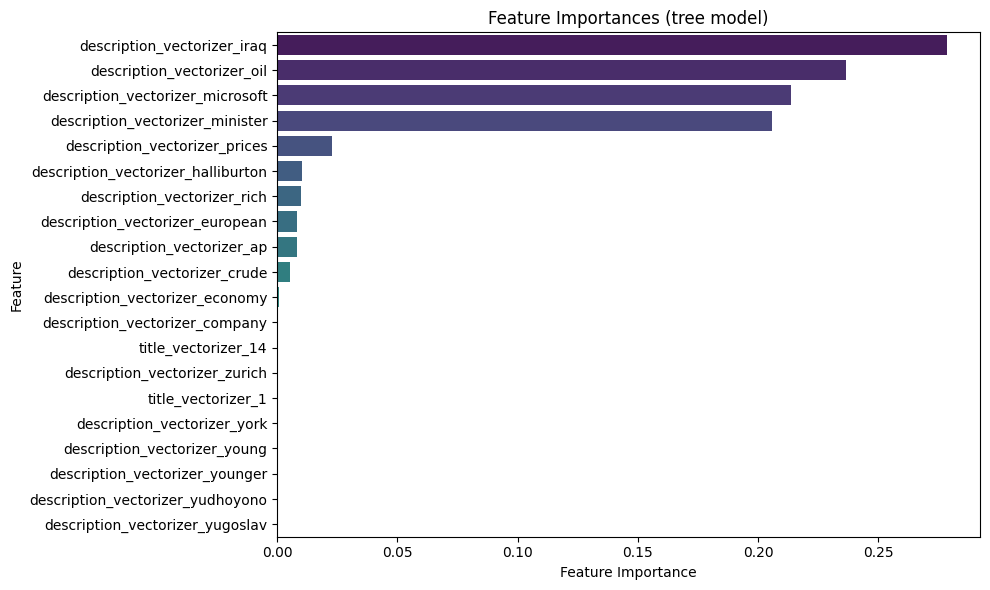

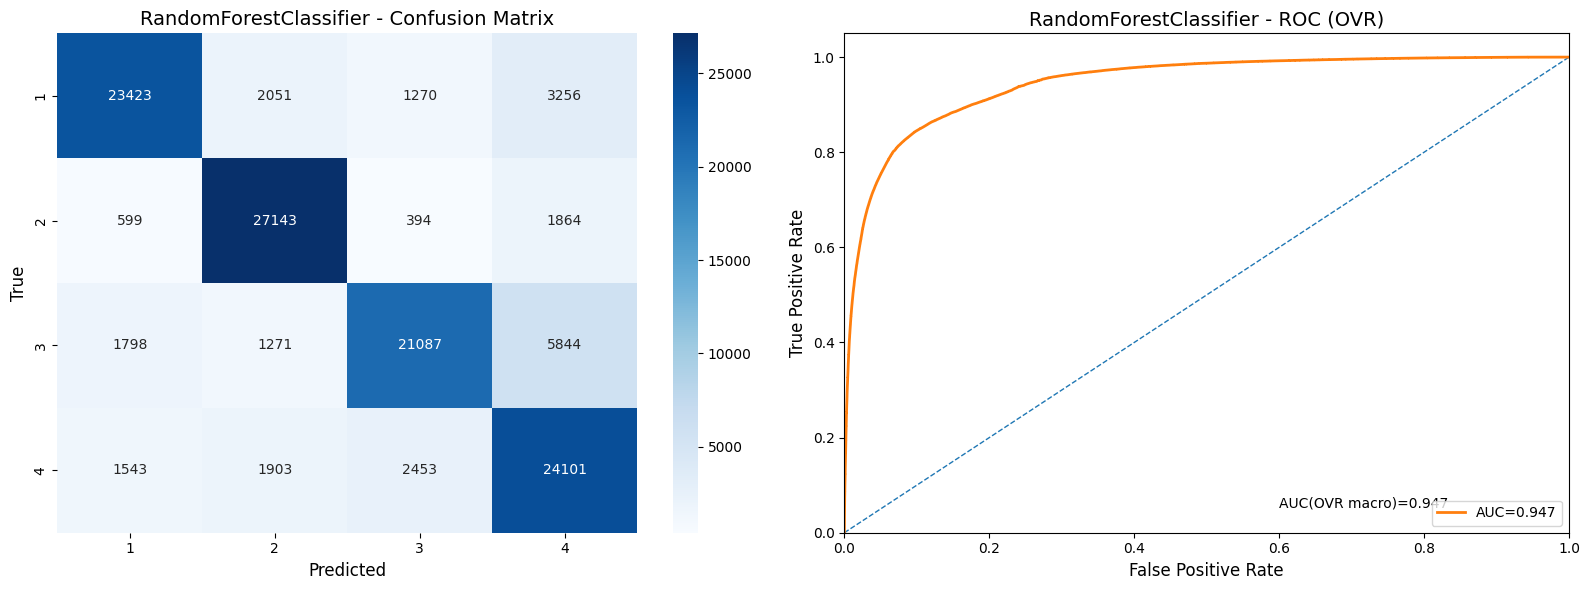

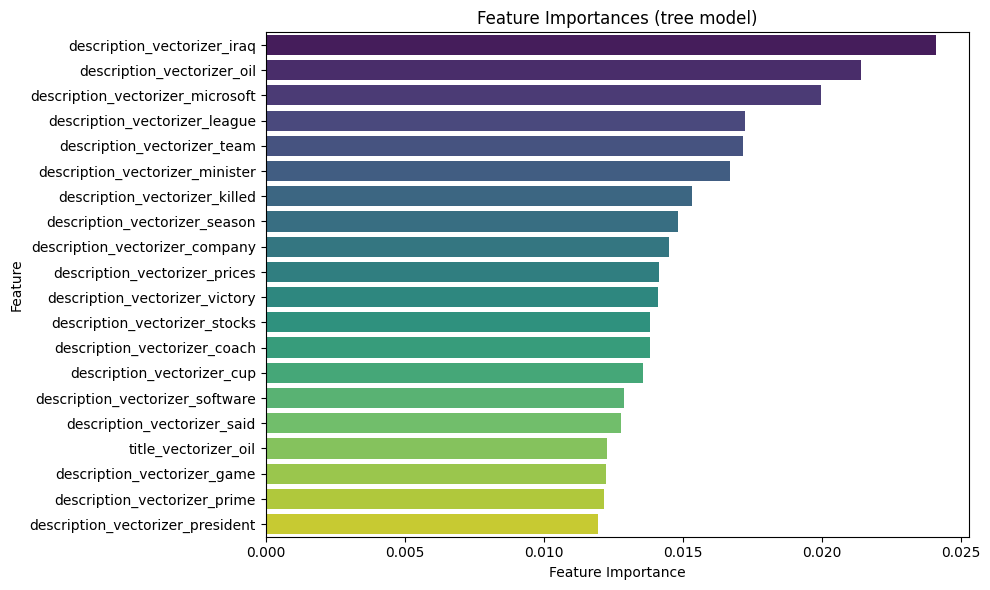

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:26

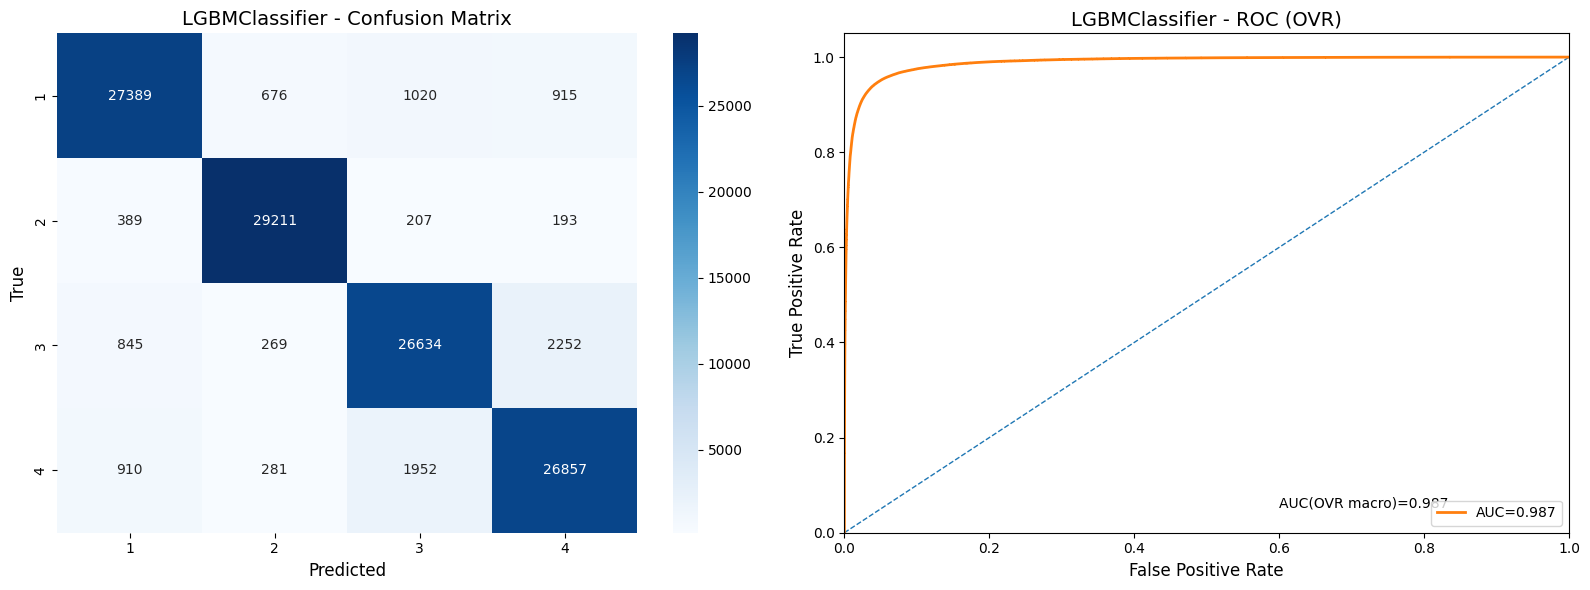

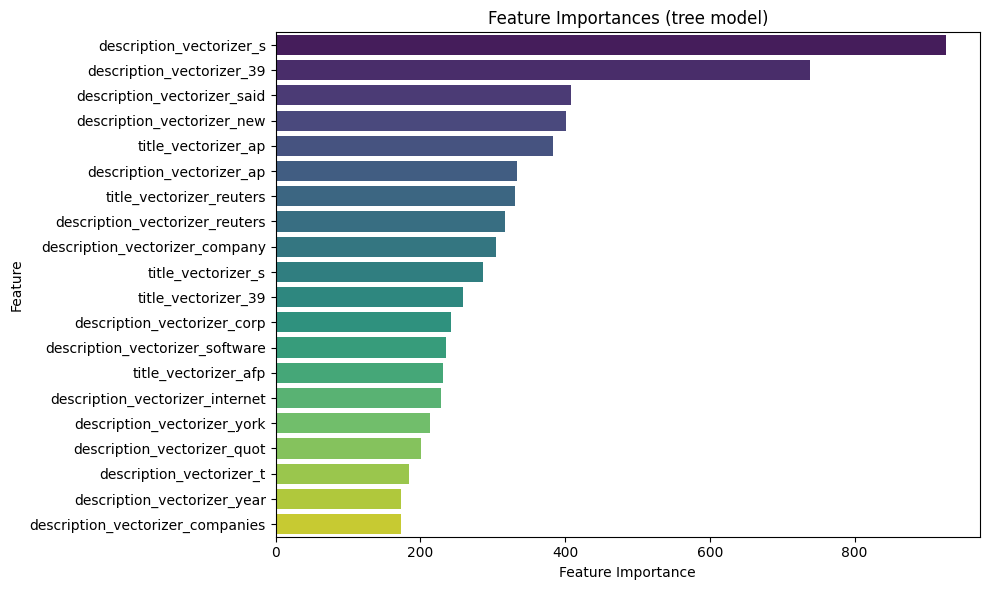

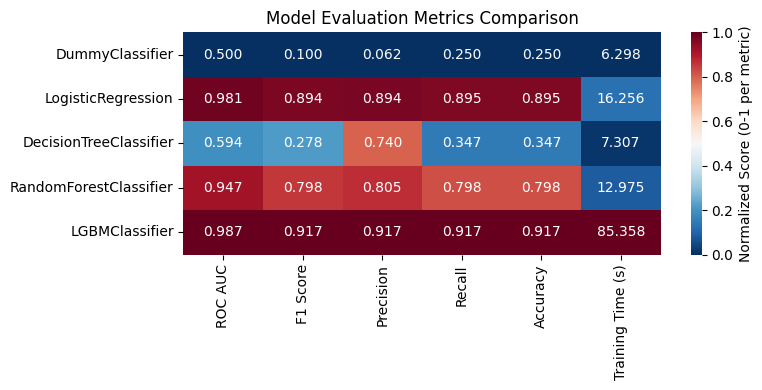

In [14]:
# Обучаем модели на очищенных от стоп-слов данных
# Сравним результаты с предыдущим экспериментом
count_vectorizer_cleaned_metrics = train_evaluate_models_cv(
    models=models,
    X=X_cleaned_tokens,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
     ROC AUC  F1 Score  Precision    Recall  Accuracy  Training Time (s)
 0  0.000000  0.000000   0.000000  0.000000  0.000000          -1.711973
 1 -0.000080 -0.000174  -0.000177 -0.000158 -0.000158         -19.325750
 2 -0.033979 -0.069441   0.097534 -0.032000 -0.032000          -1.785657
 3 -0.000217 -0.005055  -0.004283 -0.006392 -0.006392          -3.107701
 4 -0.000336 -0.000191  -0.000218 -0.000192 -0.000192          -9.727180)

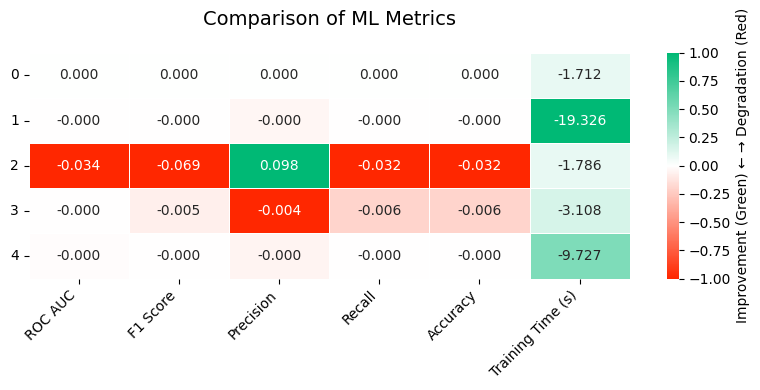

In [15]:
# Сравниваем метрики моделей до и после удаления стоп-слов
# Тепловая карта покажет, улучшилось ли качество после очистки
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_cleaned_metrics)

**Вывод по удалению стоп-слов:**

Изменение метрик незначительное, однако наблюдается ускорение времени обучения. 
Это преобразование оставим, так как:
1. Ускоряет обучение без потери качества
2. Стоп-слова в наших текстах не несут дополнительной смысловой нагрузки
3. Уменьшает размерность признакового пространства

#### 6.1.3 Удалим стоп-слова и мусор

- Явный мусор будет удалён (пустые, #NAME?, Unknown, “битые” строки).
- HTML-артефакты будут “раскодированы” и удалены: &#39;, &lt;, &gt;, #39;, теги <...> и т.п.
- Токены-мусор lt/gt/amp/... будут убраны как отдельные слова.
- Дубликаты Description будут удалены корректно, без риска оставить конфликтные метки.

In [42]:
df_raw = df_preprocessed.copy()

dfclean = clean_and_dedup_df(
    df_raw,                      # ВАЖНО: сырая таблица, где Description/Title = строки
    text_col="Description",
    label_col="Class Indиex",
    also_clean_cols=("Title",),
    drop_unknown_label=True,
)


X1, y1 = divide_data(dfclean, "Class Index")   # уже после чистк

[DEDUP] duplicates removed: 1509


In [46]:
# Создаем копию данных для экспериментов с очисткой
df_clean = X1.copy()

DROP_TOKENS = {"s", "t", "39"}

def drop_bad_tokens(tokens):
    out = []
    for tok in tokens:
        tok = str(tok).lower()
        if tok in DROP_TOKENS:
            continue
        out.append(tok)
    return out

# Удаляем стоп-слова из токенов
for col in ["Description", "Title"]:
    df_clean[col] = df_clean[col].apply(lambda s: tokenize_words(s))  # -> list[str]
    df_clean[col] = df_clean[col].apply(lambda toks: drop_bad_tokens(filter_tokens(
        toks,
        remove_stopwords=True,
        to_lower=True,
    )))

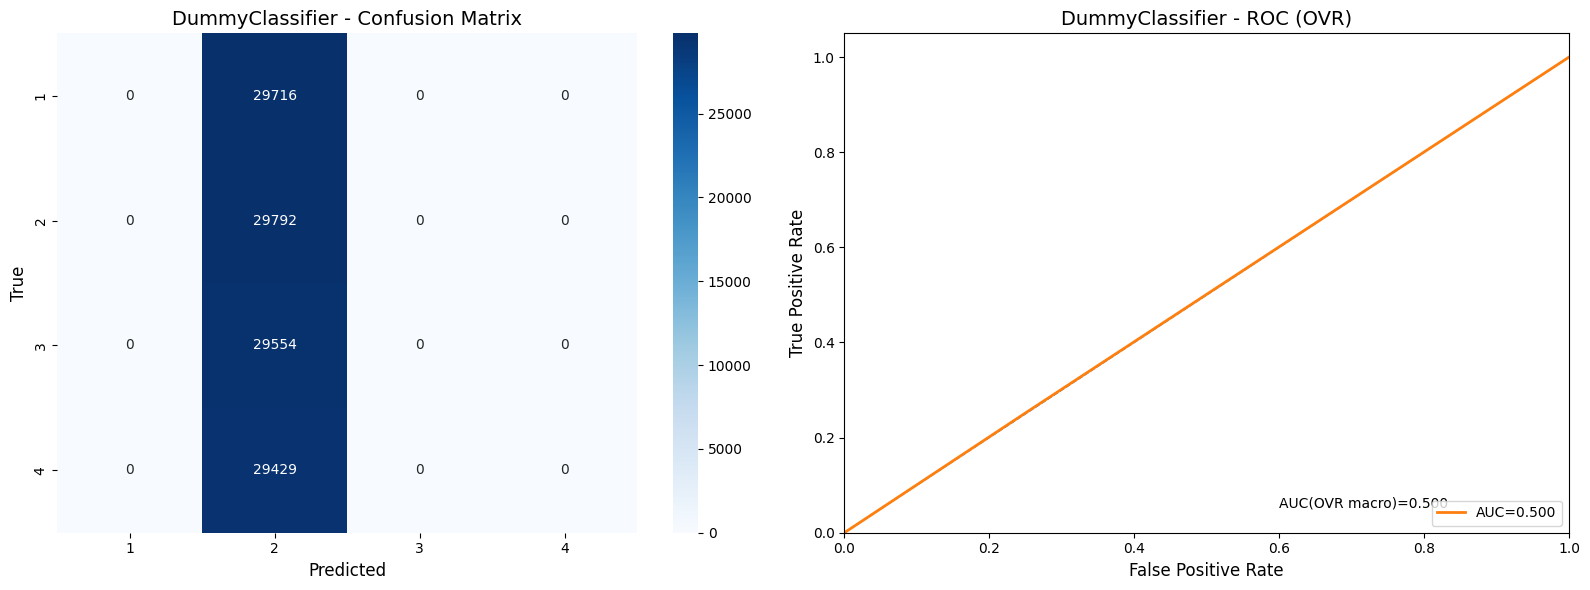

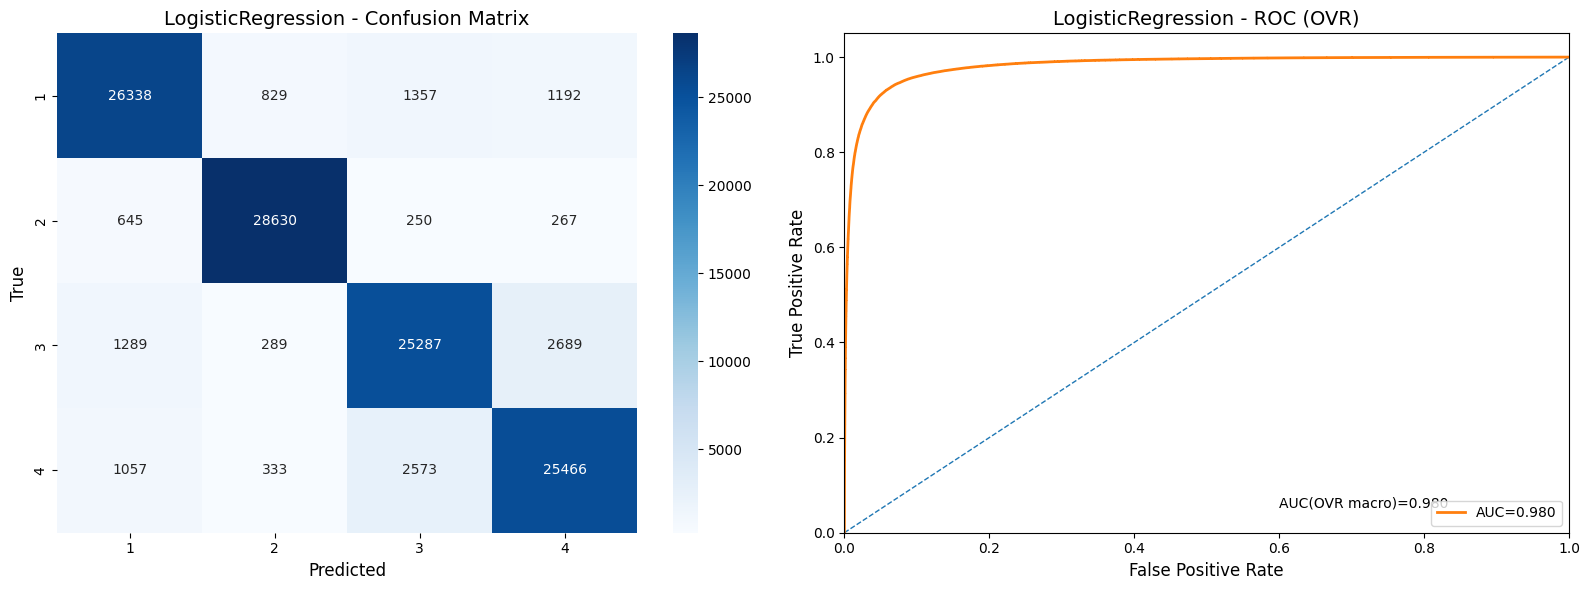

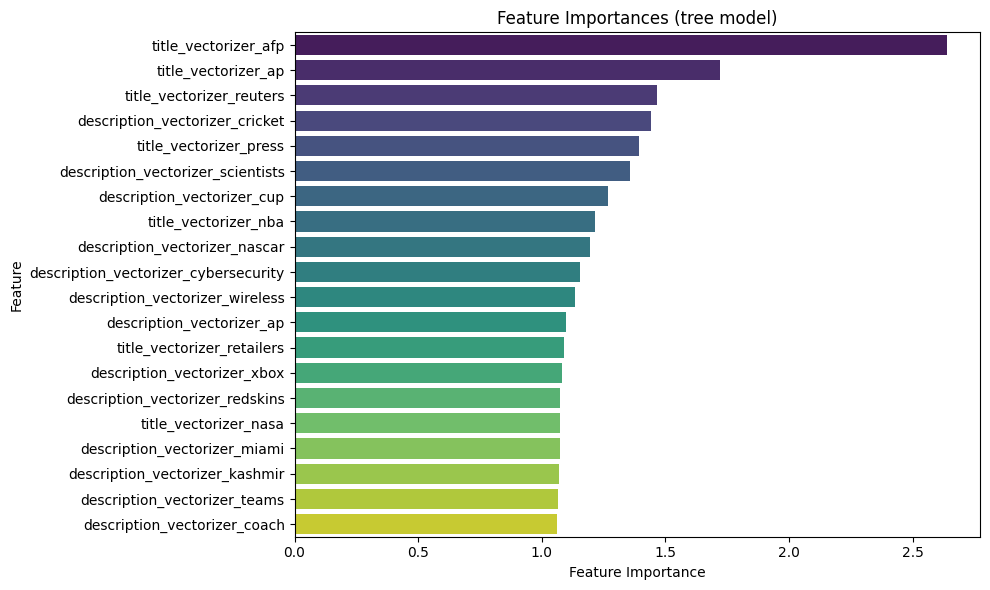

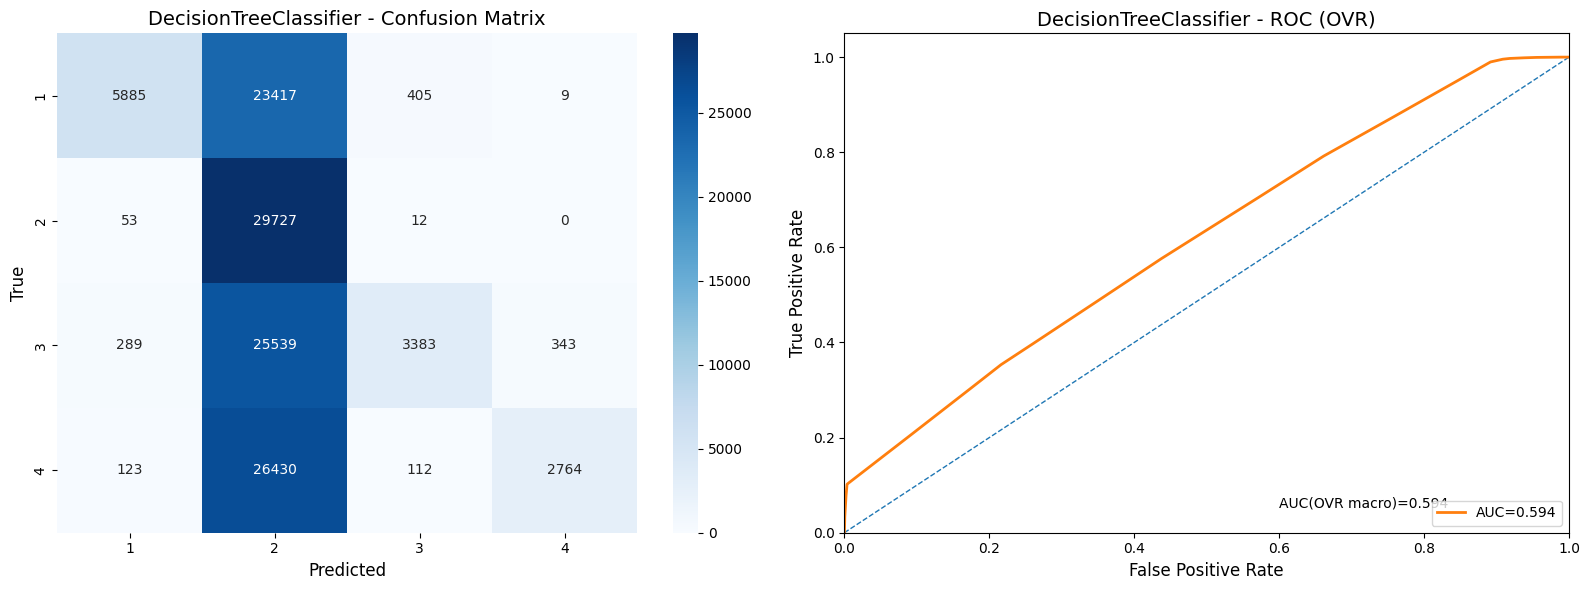

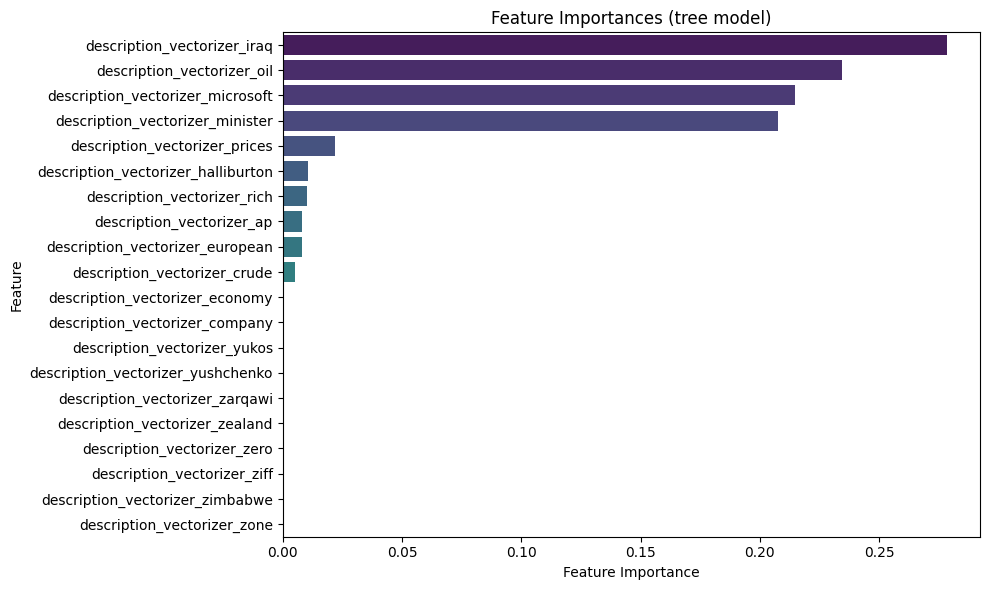

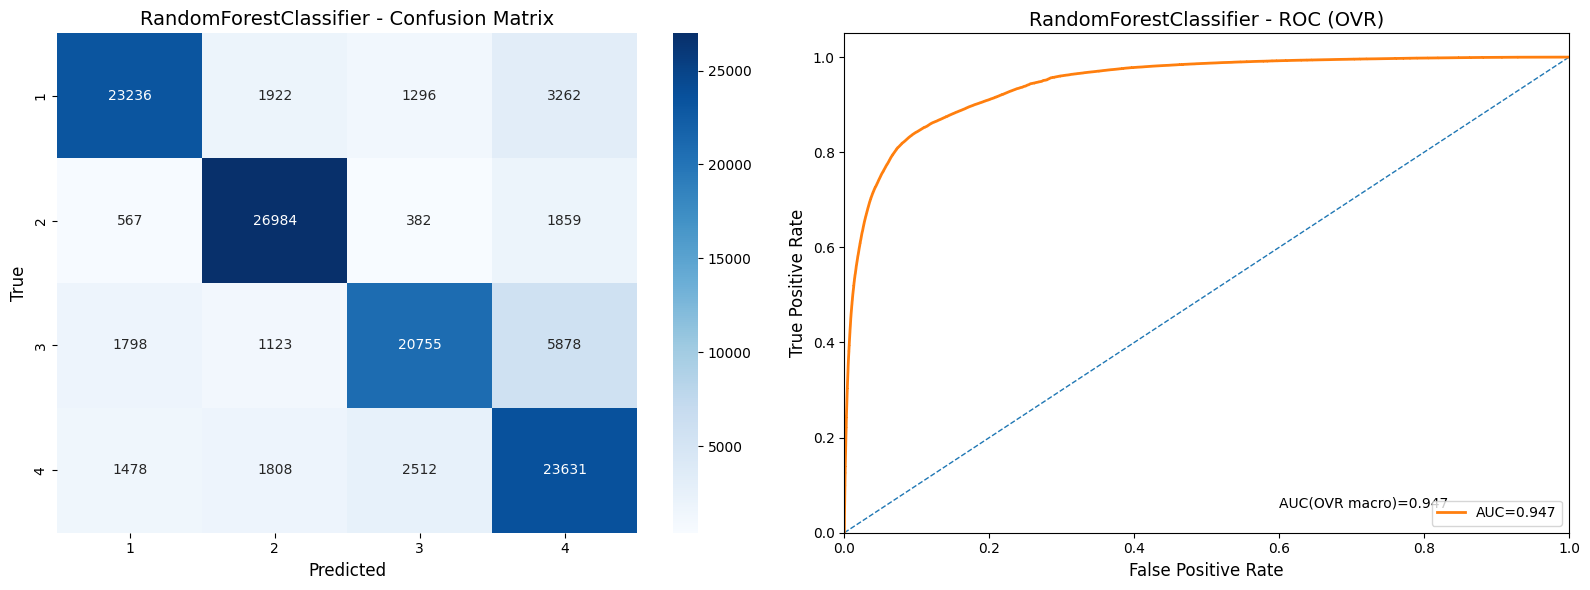

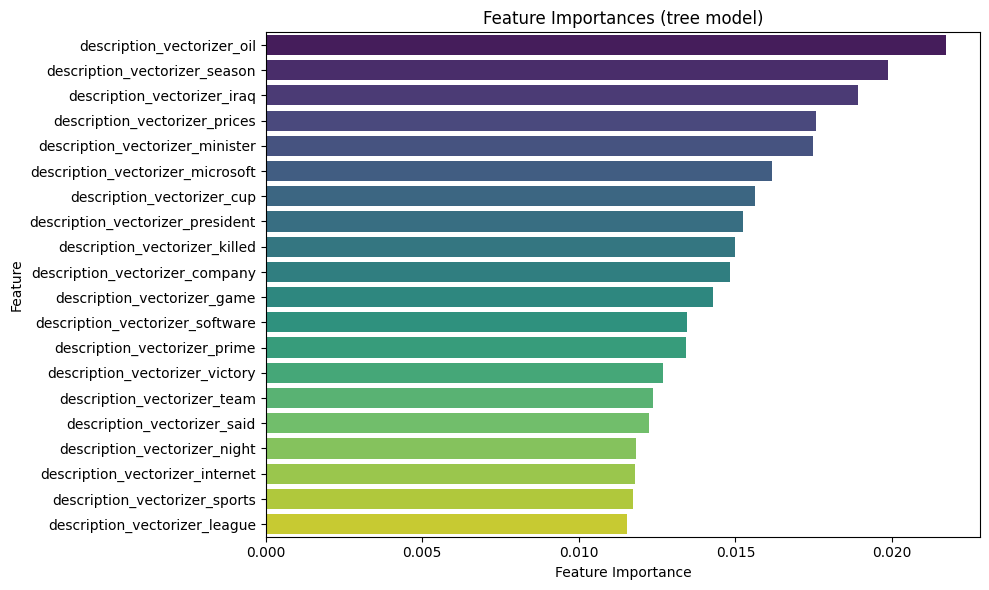

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:26

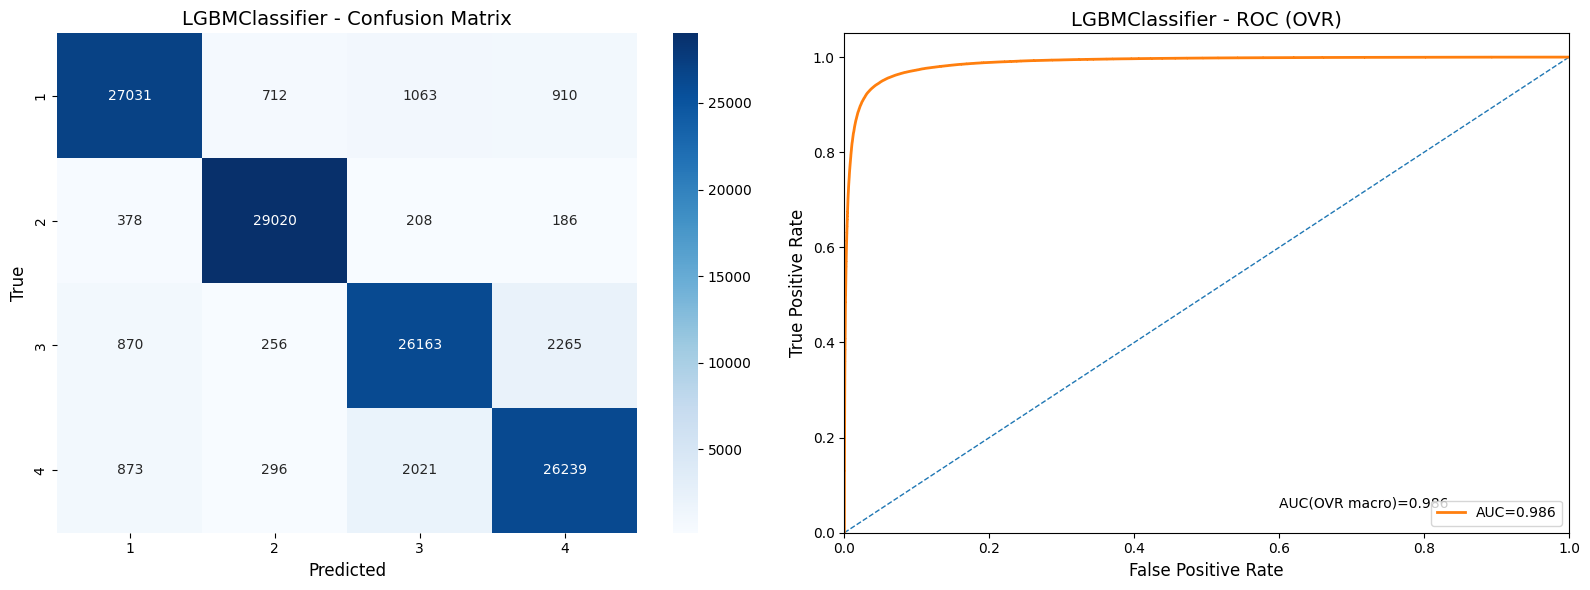

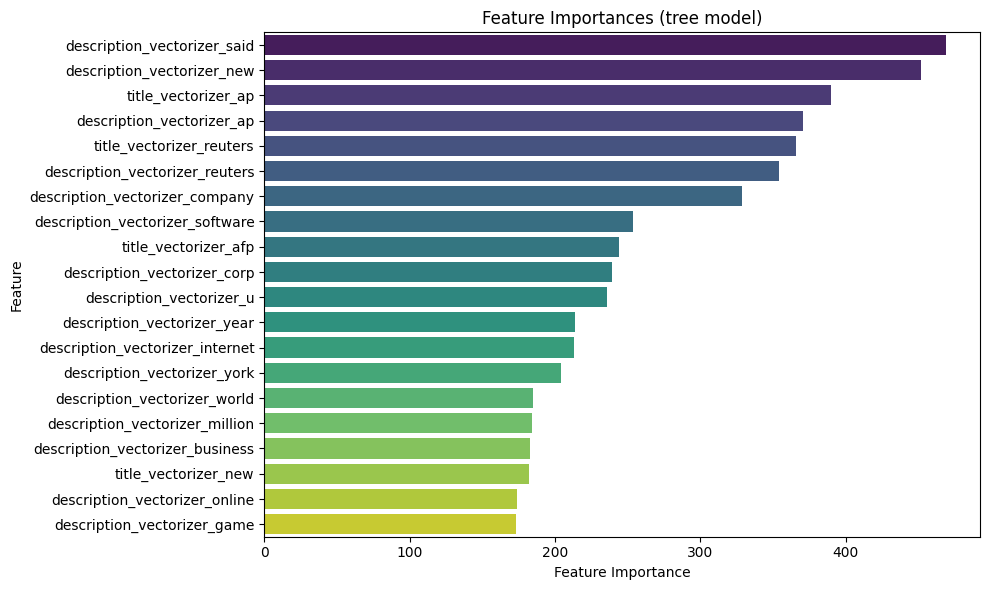

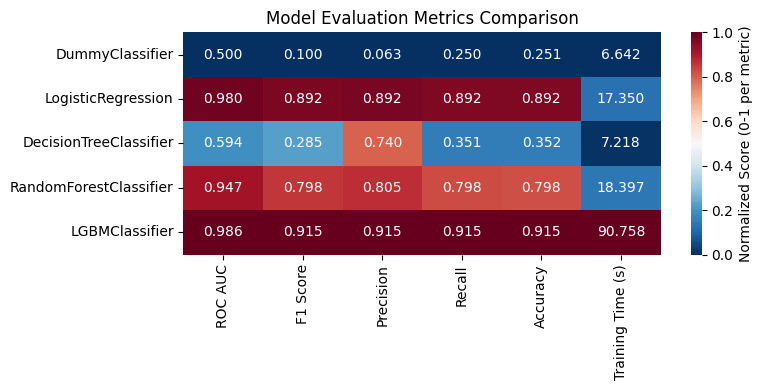

In [47]:
# Обучаем модели на очищенных от стоп-слов данных
# Сравним результаты с предыдущим экспериментом
count_vectorizer_cl_metrics = train_evaluate_models_cv(
    models=models,
    X=df_clean,
    y=y1,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
     ROC AUC  F1 Score  Precision    Recall  Accuracy  Training Time (s)
 0  0.000000  0.000457   0.000357  0.000000  0.001428           0.343255
 1 -0.000915 -0.002436  -0.002410 -0.002464 -0.002305           1.093804
 2 -0.000339  0.007241   0.000071  0.004312  0.005673          -0.088352
 3 -0.000732  0.000341   0.000121  0.000285  0.000473           5.422570
 4 -0.000964 -0.002284  -0.002275 -0.002276 -0.002140           5.400378)

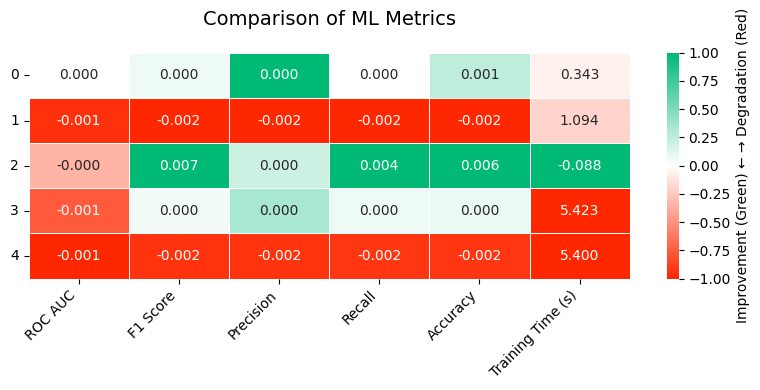

In [48]:
compare_metrics_heatmap(count_vectorizer_cleaned_metrics, count_vectorizer_cl_metrics)

метрики особо не поменялись

#### 6.1.3 Топ 100 важных токенов

**Логика:** Вместо использования всех токенов, выбираем только самые важные для классификации.
Это может улучшить качество линейных моделей и ускорить обучение.

In [20]:
# Создаем пайплайн с отбором топ-100 важных токенов
count_vectorizer_important_tokens_preprocessor = Pipeline([
    (
        'columns',
        ColumnTransformer([
            # Пайплайн для заголовков: сначала отбираем важные токены, потом векторизуем
            (
                'Title_pipeline',
                Pipeline([
                    ('token_selector', NgramFeatureSelector(top_k=100)),  # отбираем топ-100 токенов
                    ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=10, dtype=np.float32)),
                ]),
                'Title'
            ),
            # Аналогично для описаний
            (
                'Description_pipeline',
                Pipeline([
                    ('token_selector', NgramFeatureSelector(top_k=100)),
                    ('vectorizer', CountVectorizer(analyzer=lambda x: x, min_df=10, dtype=np.float32)),
                ]),
                'Description'
            ),
        ],
            remainder='drop',
            verbose_feature_names_out=True
        )
    ),
])

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526

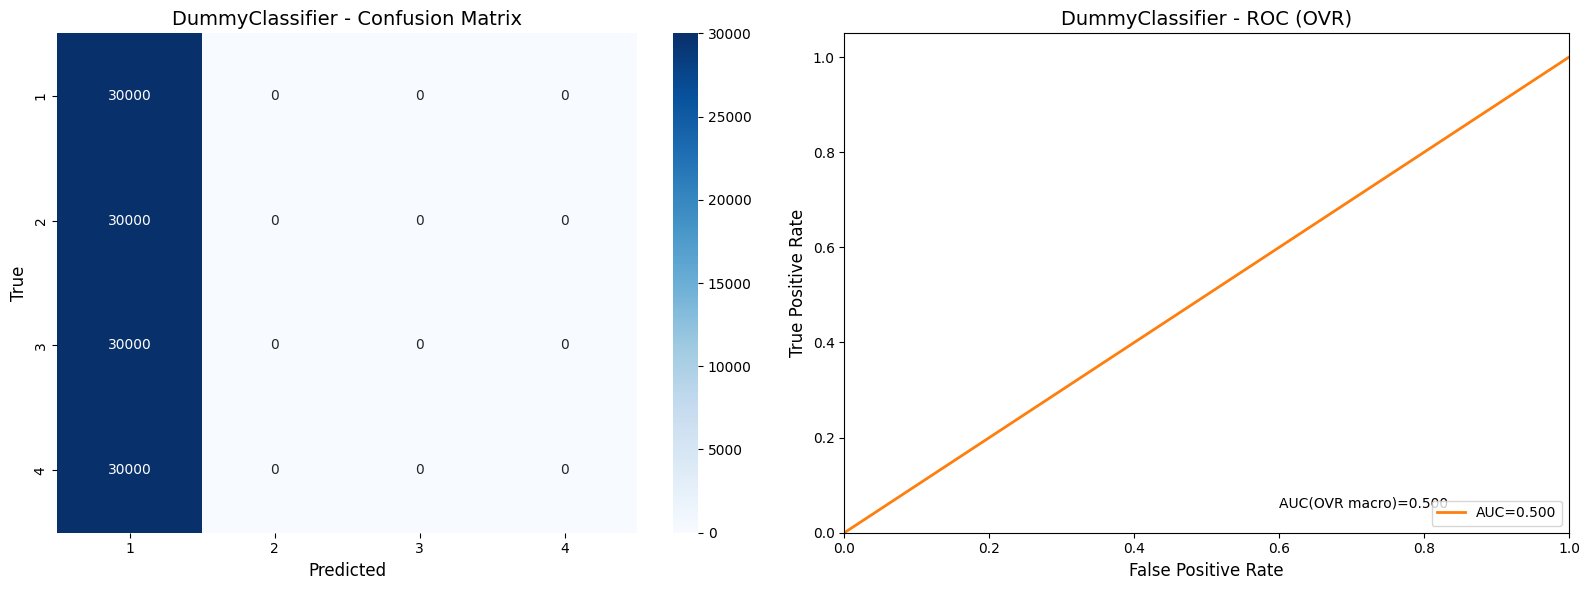

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526

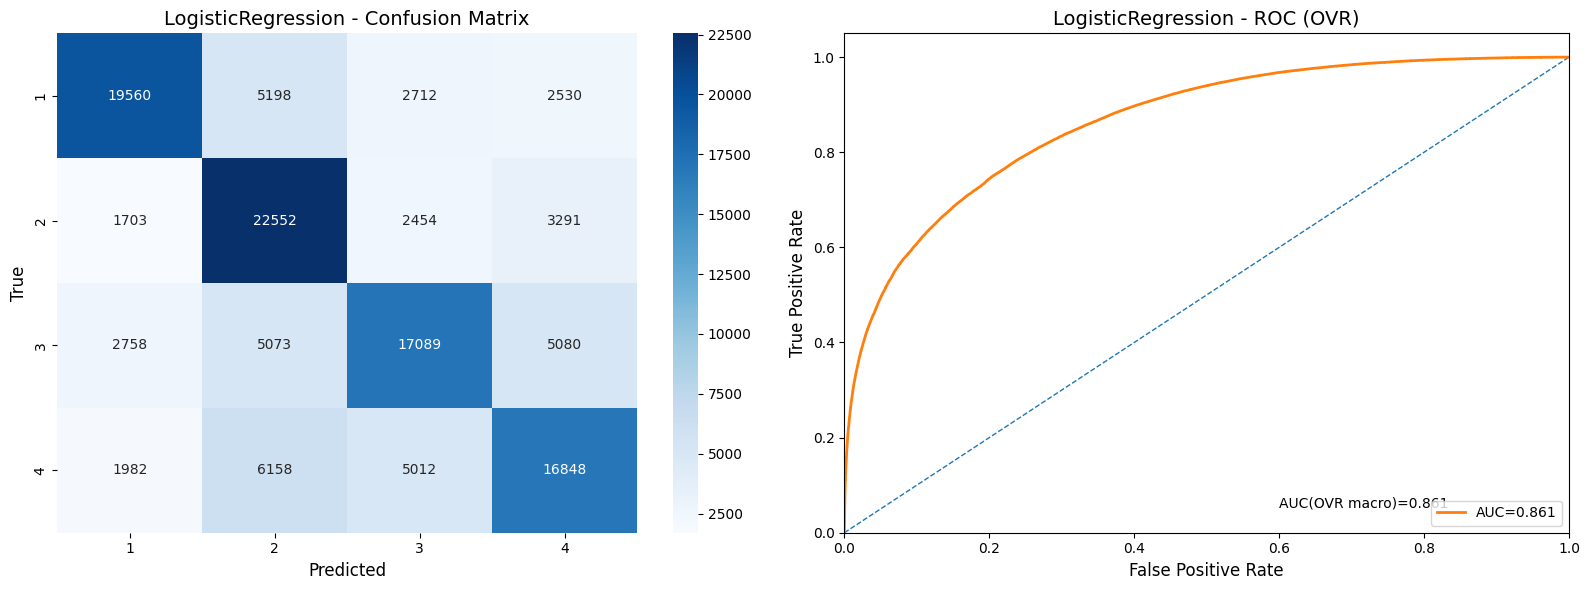

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


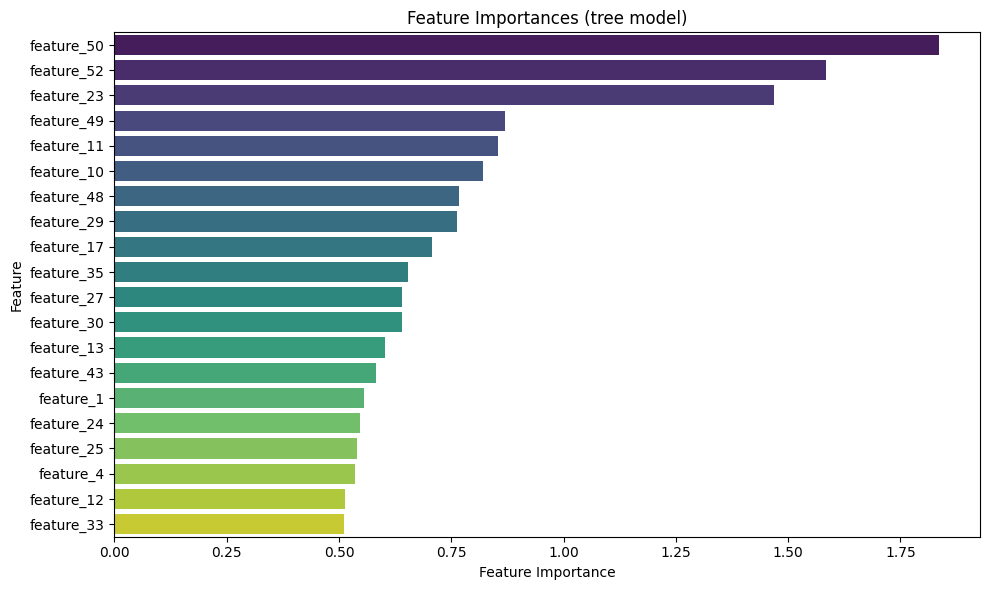

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526

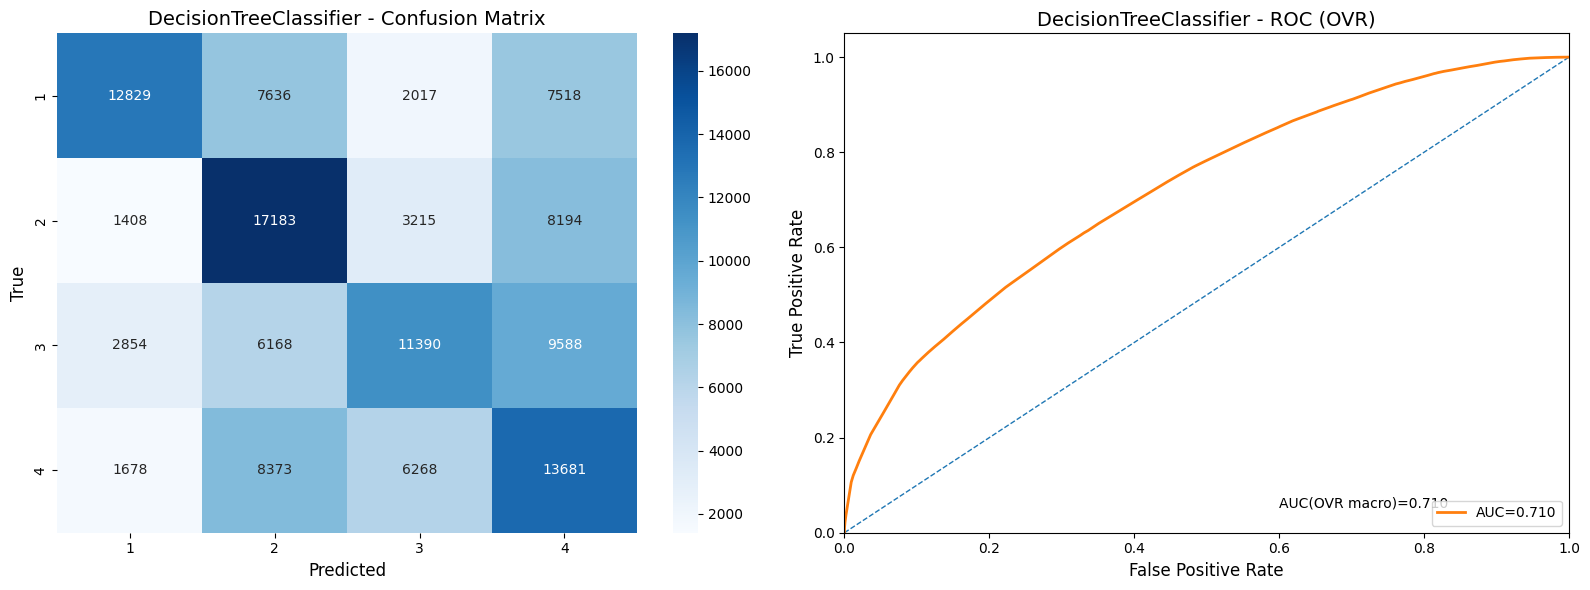

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


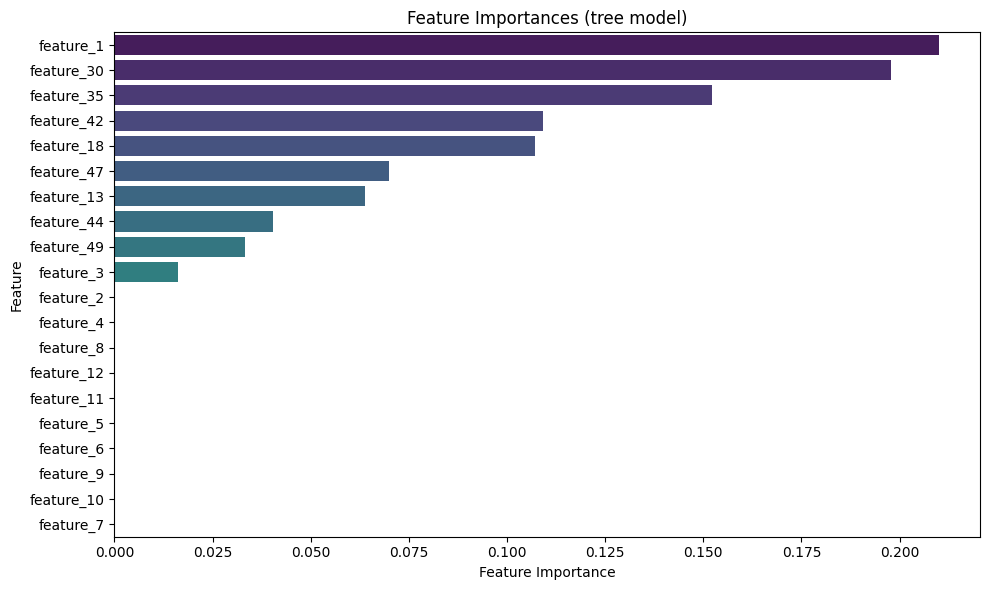

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526

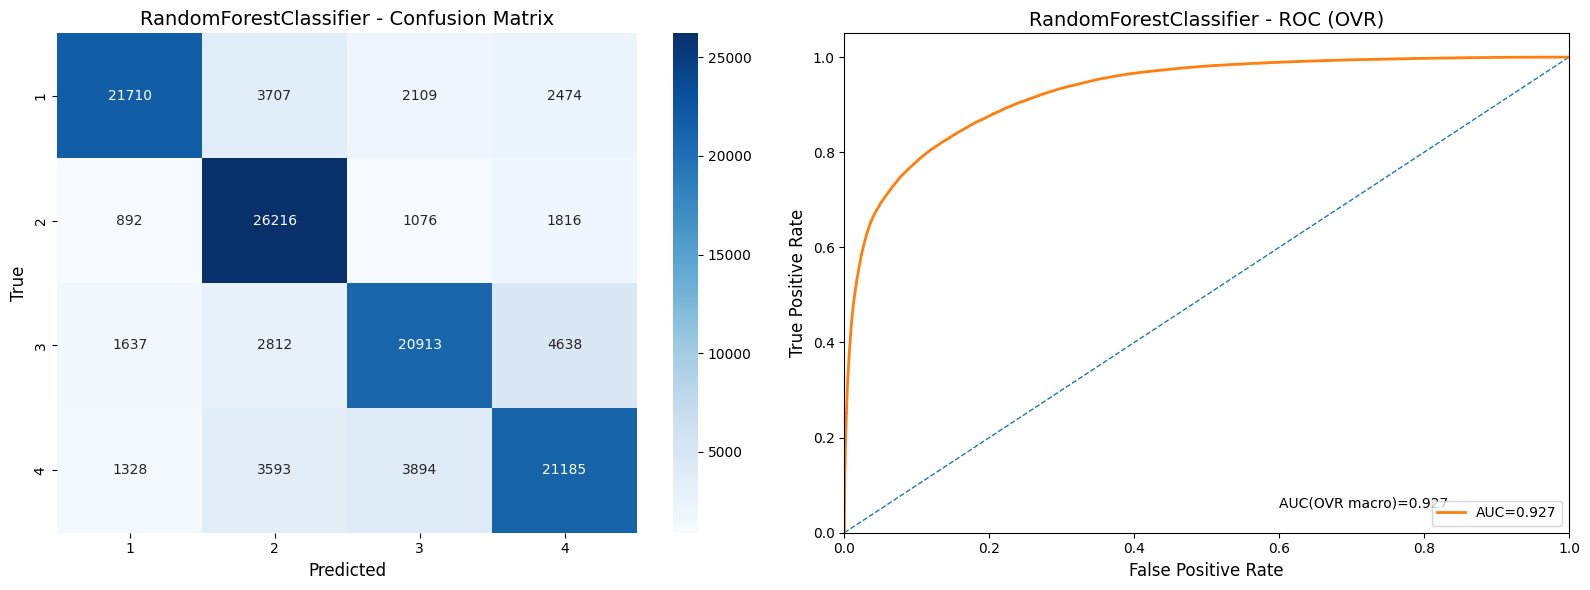

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


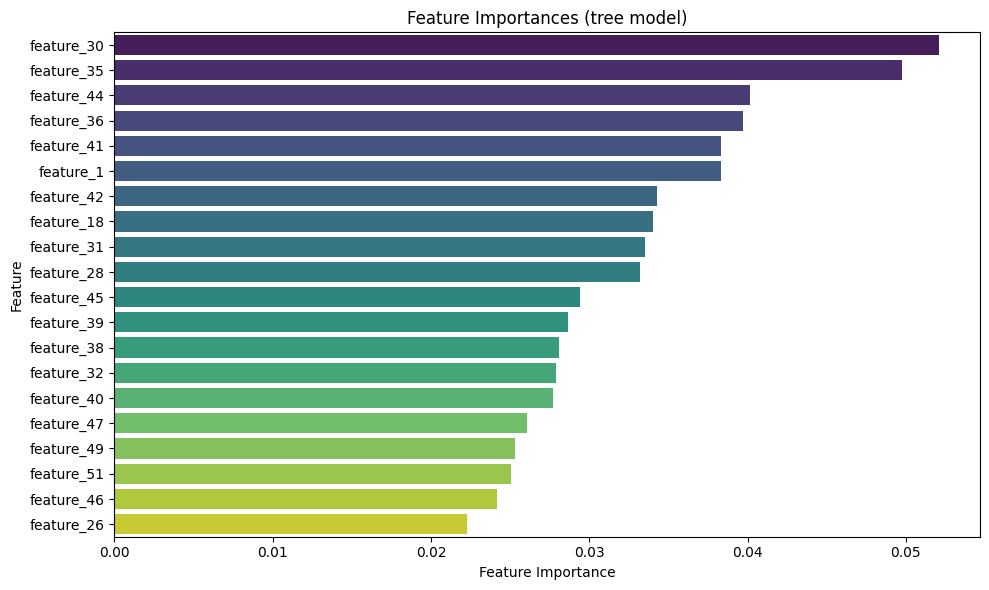

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py

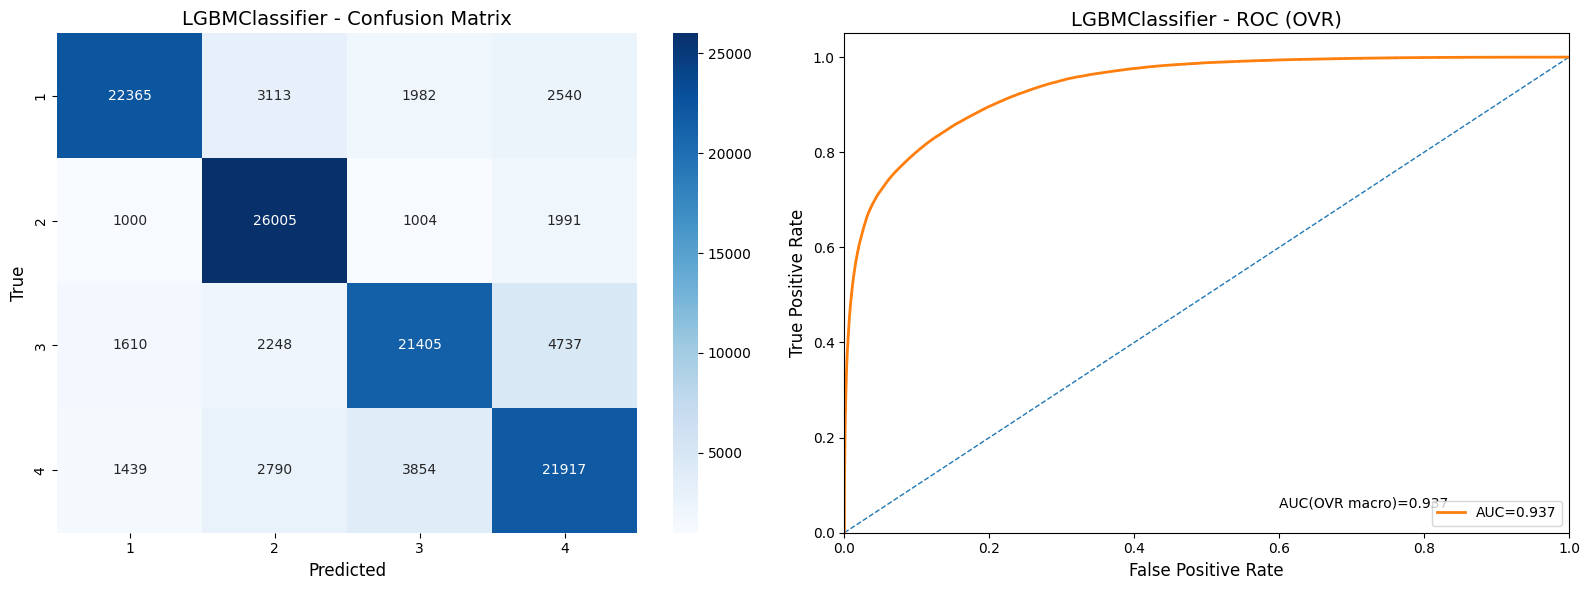

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


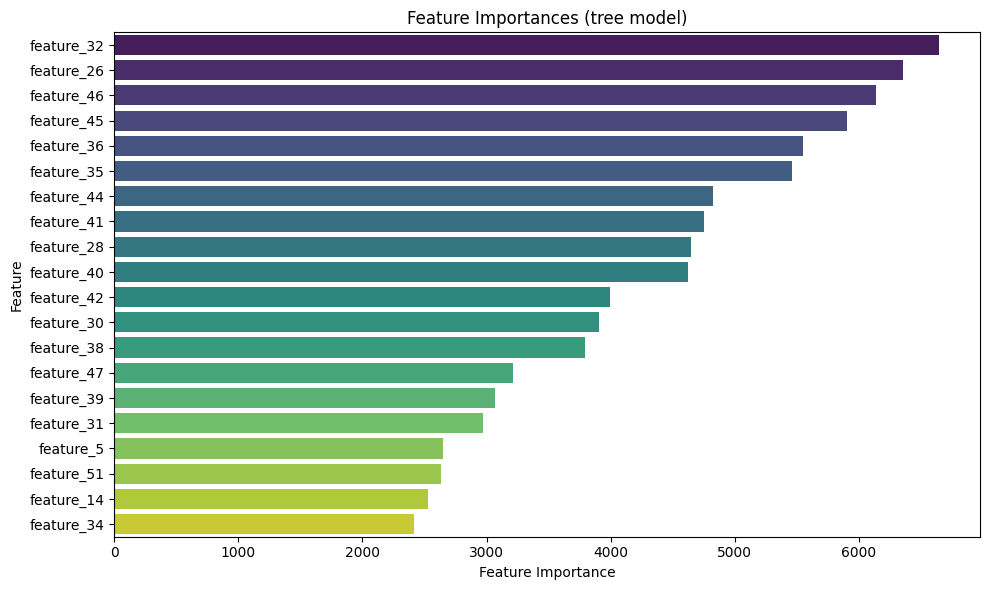

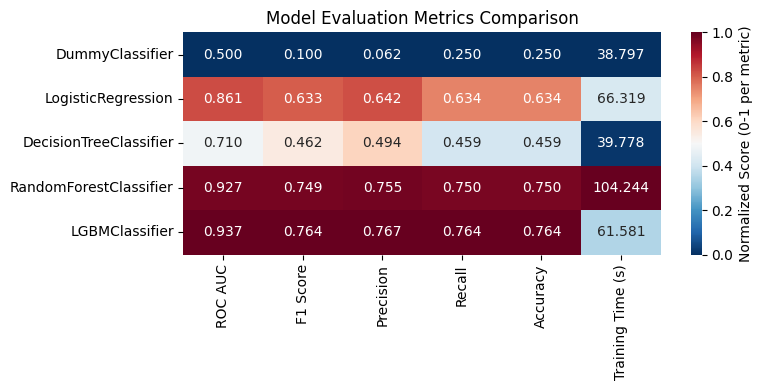

In [21]:
# Обучаем модели с отбором важных токенов
# Используем исходные данные (не очищенные от стоп-слов), так как отбор токенов делается на основе важности
count_vectorizer_important_tokens_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_important_tokens_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
     ROC AUC  F1 Score  Precision    Recall  Accuracy  Training Time (s)
 0  0.000000  0.000000   0.000000  0.000000  0.000000          30.786597
 1 -0.119601 -0.261479  -0.253046 -0.260950 -0.260950          30.737455
 2  0.081706  0.114869  -0.149199  0.080275  0.080275          30.686101
 3 -0.020921 -0.053571  -0.053886 -0.054142 -0.054142          88.161681
 4 -0.050336 -0.153771  -0.150124 -0.153517 -0.153517         -33.503653)

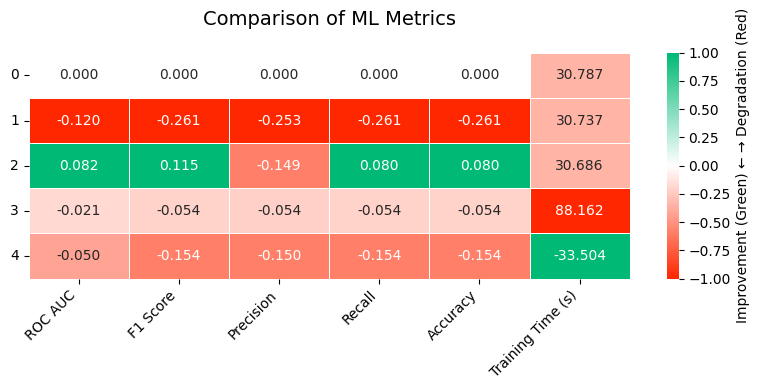

In [22]:
# Сравниваем результаты с отбором важных токенов и без него
compare_metrics_heatmap(count_vectorizer_metrics, count_vectorizer_important_tokens_metrics)

**Вывод по отбору важных токенов:**

Единственное заметное улучшение — у DecisionTreeClassifier.

**Проблемы:**
- Сильно увеличилось время обучения за счет долгого пересчета n-грамм
- Для ансамблей (RandomForest, LGBM) качество в среднем снизилось — им полезнее иметь широкий набор признаков и отбирать их внутренними механизмами.

**Рекомендация:** Применять такое преобразование имеет смысл только для дерева решений.

### 6.2. TfidfVectorizer

**Логика:** TF-IDF (Term Frequency-Inverse Document Frequency) учитывает не только частоту слова в документе,
но и редкость слова в корпусе. Это может дать лучшие результаты, чем простой подсчет частот.

#### 6.2.1 Без очистки токенов

**Цель:** Проверить базовое качество TF-IDF векторизации с исходными токенами.

In [23]:
# Создаем пайплайн для TF-IDF векторизации
tfidf_vectorizer_preprocessor = Pipeline([
    ('vectorizer', ColumnTransformer(
        [
            # TF-IDF векторизация заголовков: min_df=10 исключает редкие слова
            ('Title_vectorizer', TfidfVectorizer(analyzer=lambda x: x, min_df=10, dtype=np.float32), 'Title'),
            # TF-IDF векторизация описаний
            ('Description_vectorizer', TfidfVectorizer(analyzer=lambda x: x, min_df=10, dtype=np.float32), 'Description'),
        ],
        remainder='drop', 
        verbose_feature_names_out=True
    )),
])

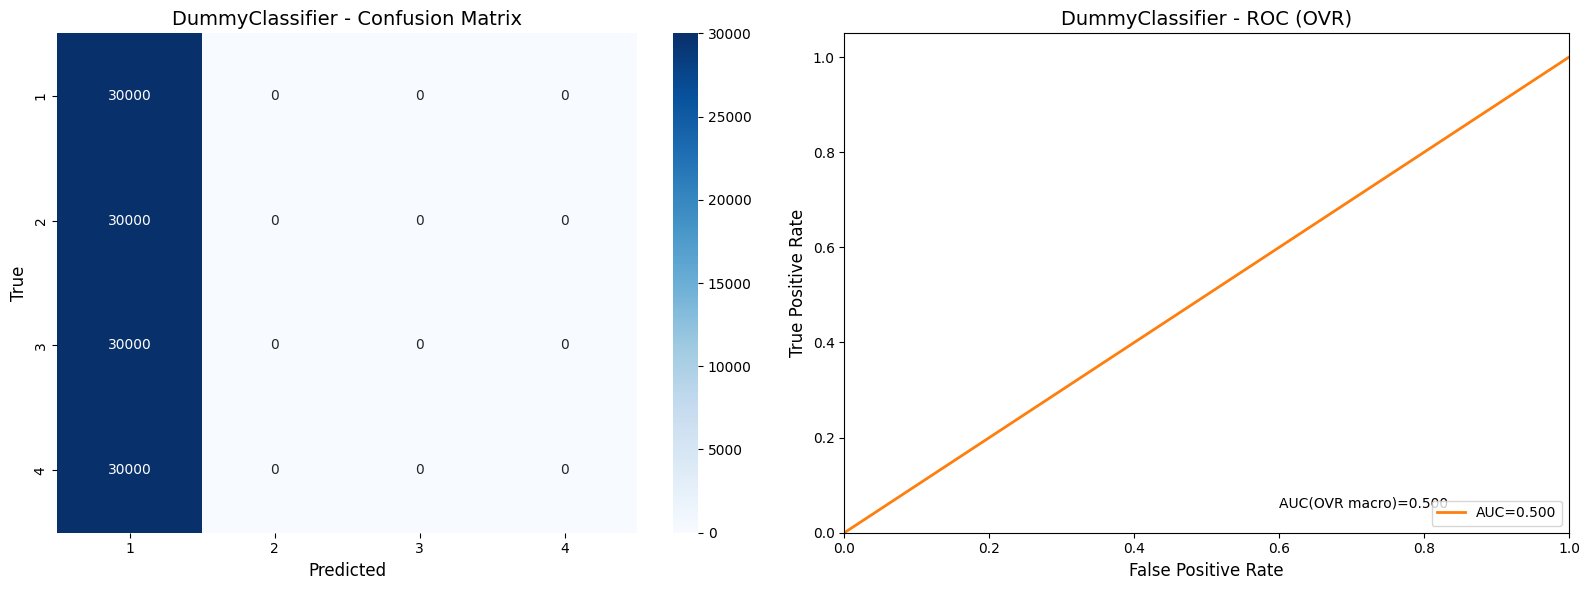

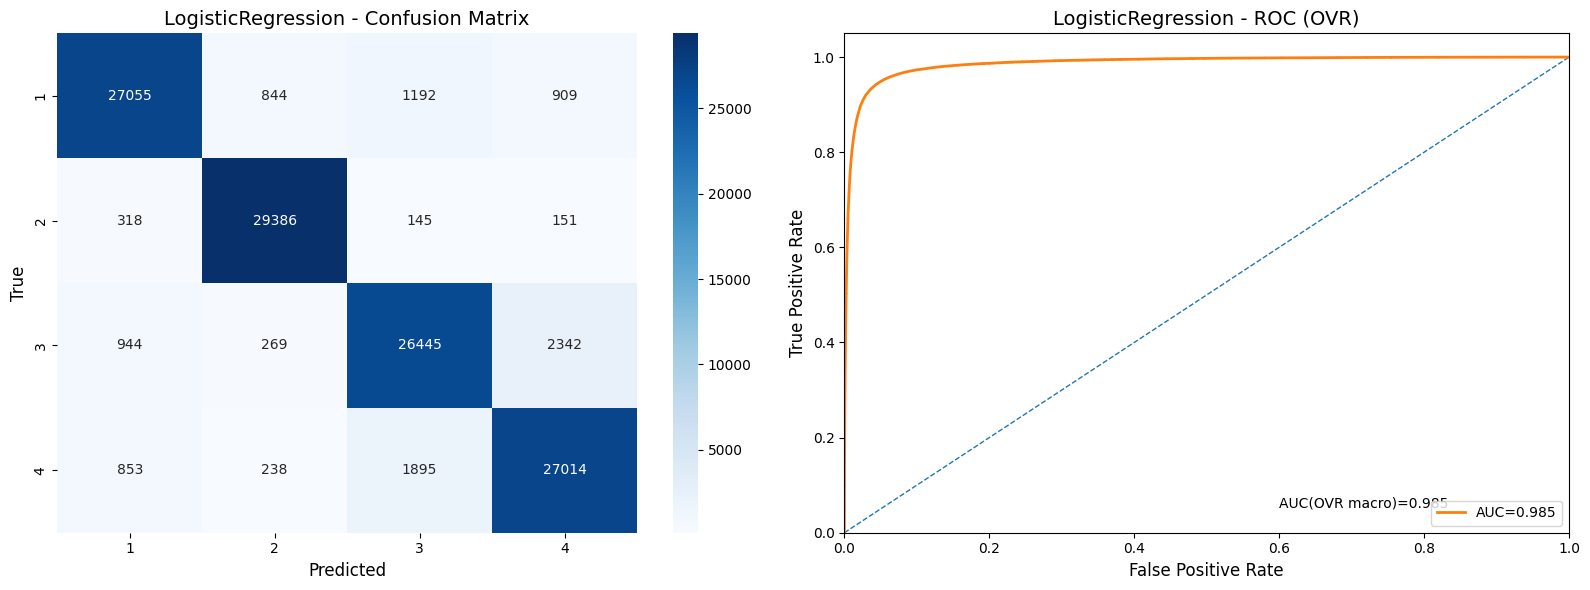

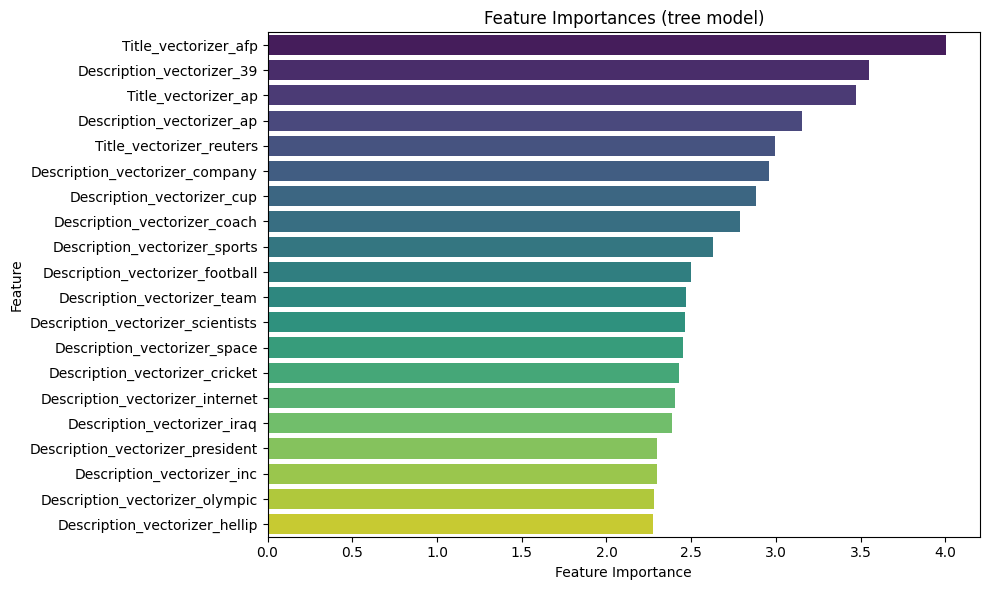

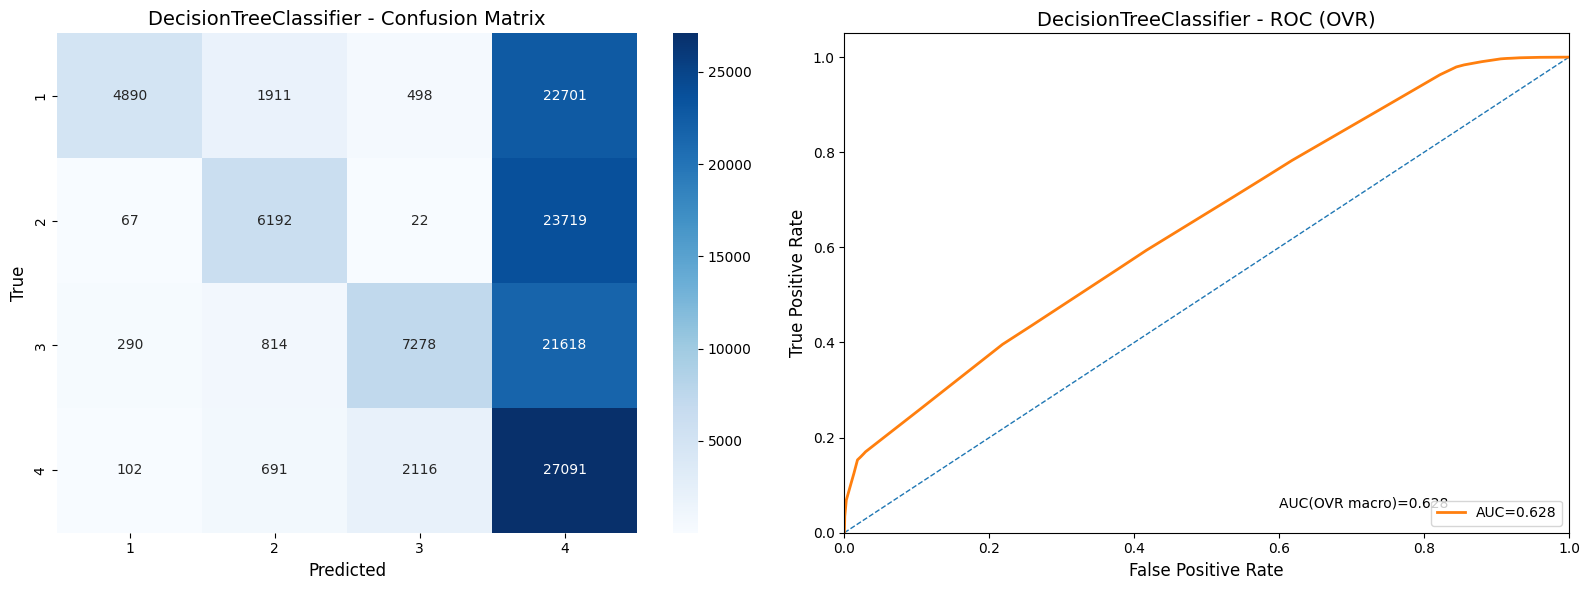

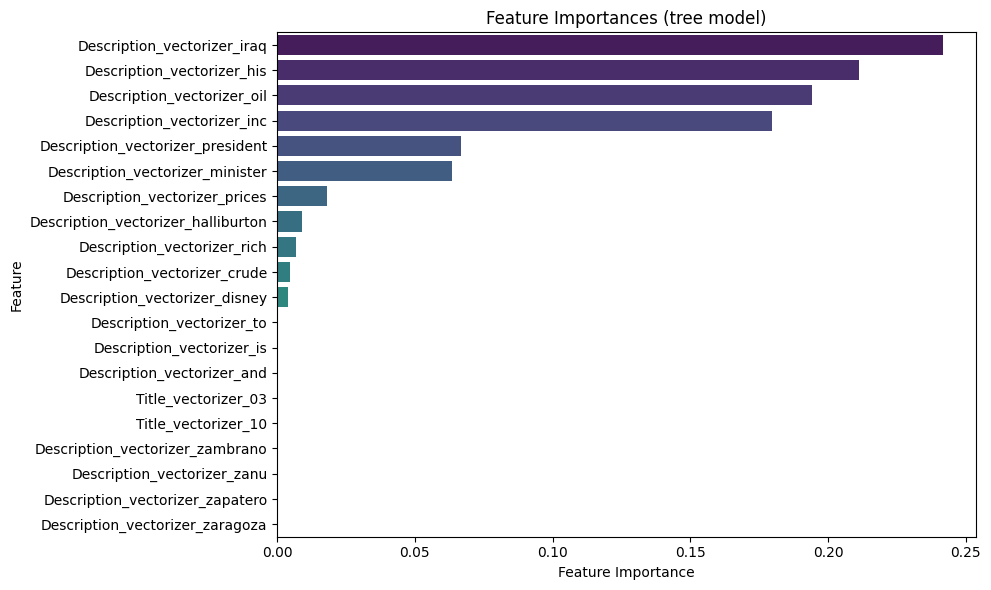

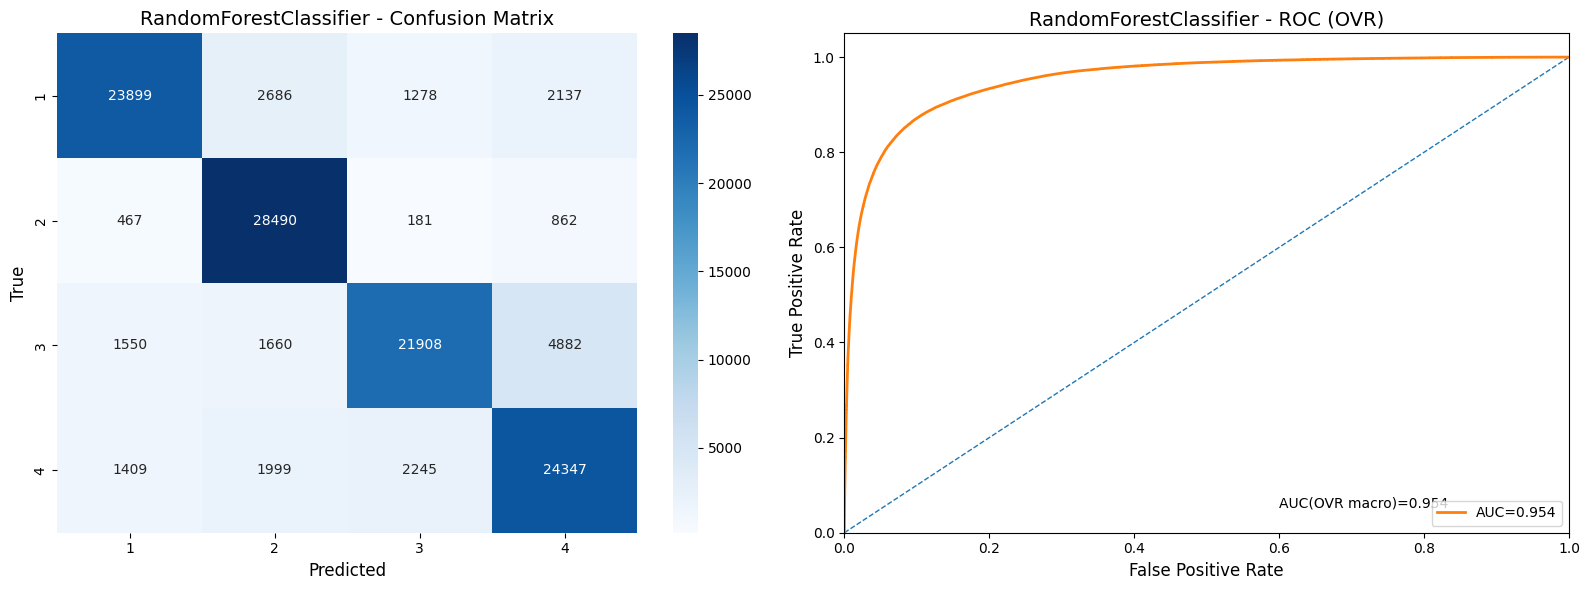

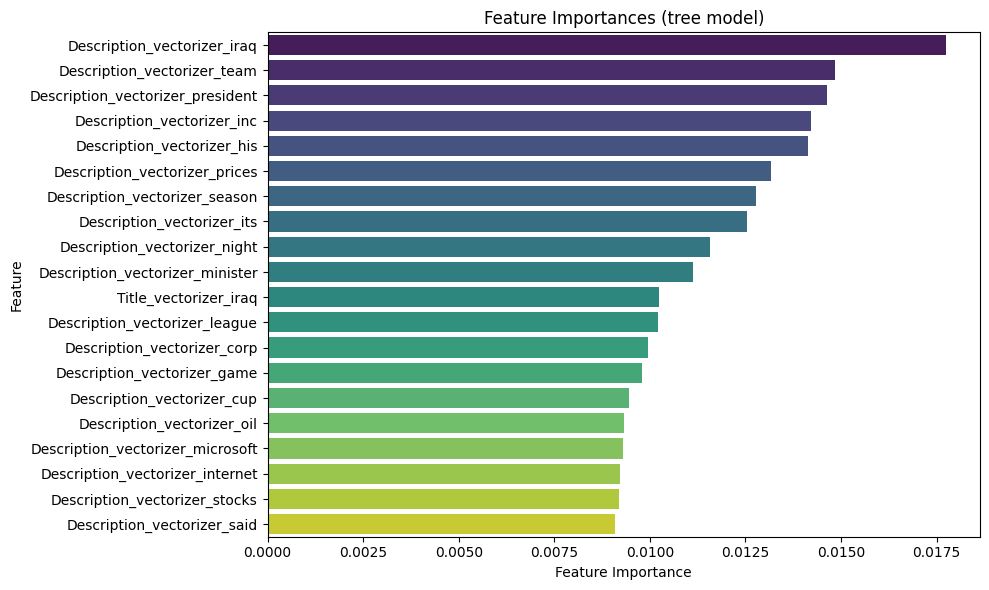

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:26

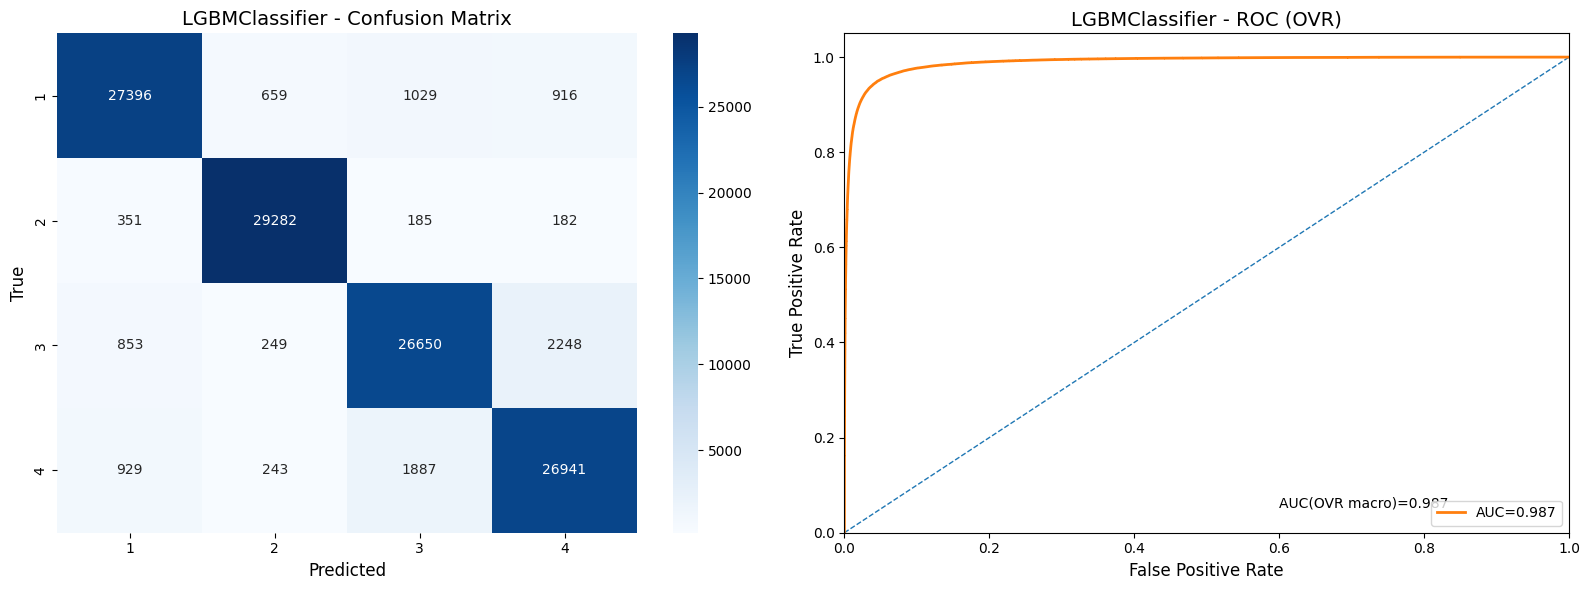

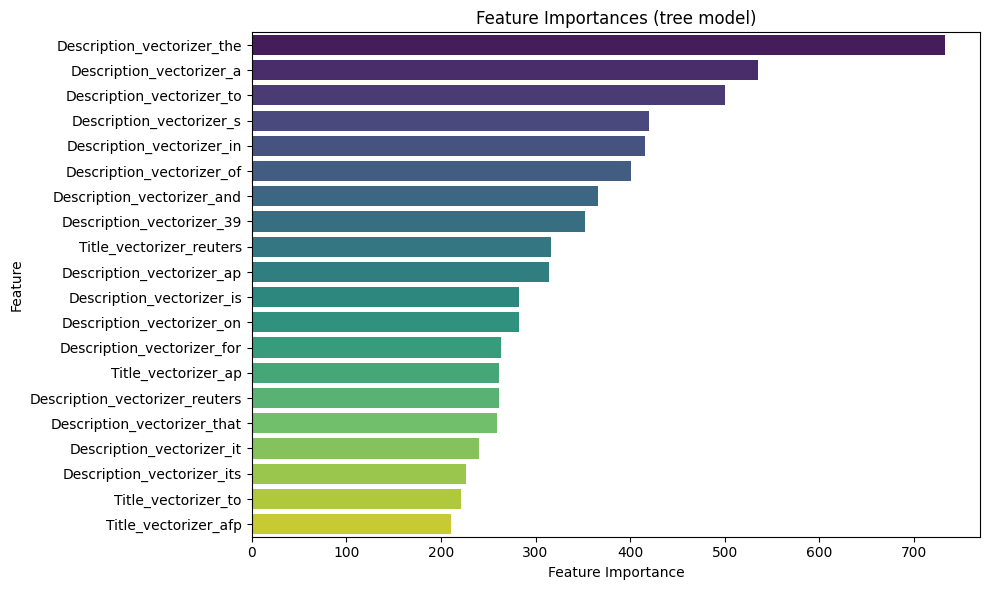

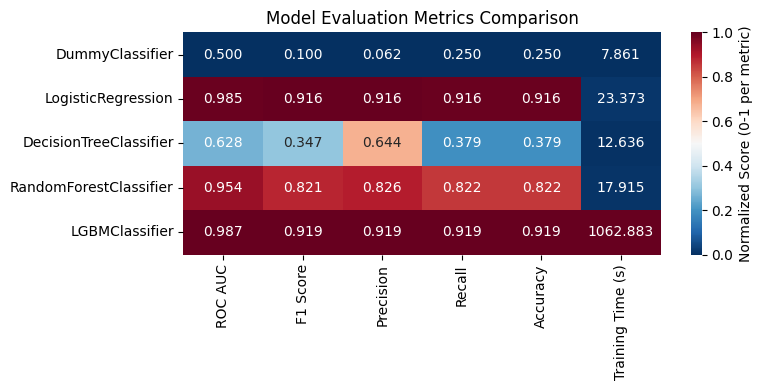

In [24]:
# Обучаем модели с TF-IDF векторизацией на исходных данных
tfidf_vectorizer_metrics = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
     ROC AUC  F1 Score  Precision    Recall  Accuracy  Training Time (s)
 0  0.000000  0.000000   0.000000  0.000000  0.000000          -0.149074
 1  0.004045  0.021060   0.021134  0.021142  0.021142         -12.208651
 2 -0.000047 -0.000213   0.001494  0.000008  0.000008           3.543845
 3  0.006454  0.017702   0.016611  0.017692  0.017692           1.833031
 4  0.000012  0.001291   0.001268  0.001292  0.001292         967.797873)

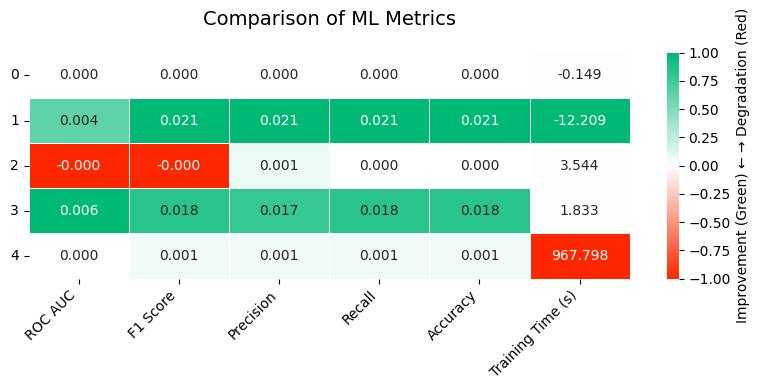

In [25]:
# Сравниваем CountVectorizer и TfidfVectorizer
compare_metrics_heatmap(count_vectorizer_metrics, tfidf_vectorizer_metrics)

**Вывод:**

Переход к TF-IDF дал небольшое, но стабильное улучшение качества для большинства моделей. Наибольший прирост наблюдается у логистической регрессии и RandomForest, для DecisionTree эффект близок к нулю/слегка отрицательный, а для LGBM прирост качества практически отсутствует.

Проблемы:

- Улучшение метрик незначительное (порядка сотых).
- Для LGBM время обучения резко выросло, тогда как выигрыш по качеству почти нулевой.

Рекомендация: Использовать TF-IDF как базовую векторизацию (особенно для линейных моделей и RandomForest), но для LGBM оставаться на CountVectorizer, так как стоимость по времени не окупается.

#### 6.2.2 Удаление стоп-слов

**Цель:** Проверить, улучшится ли качество TF-IDF после удаления стоп-слов.

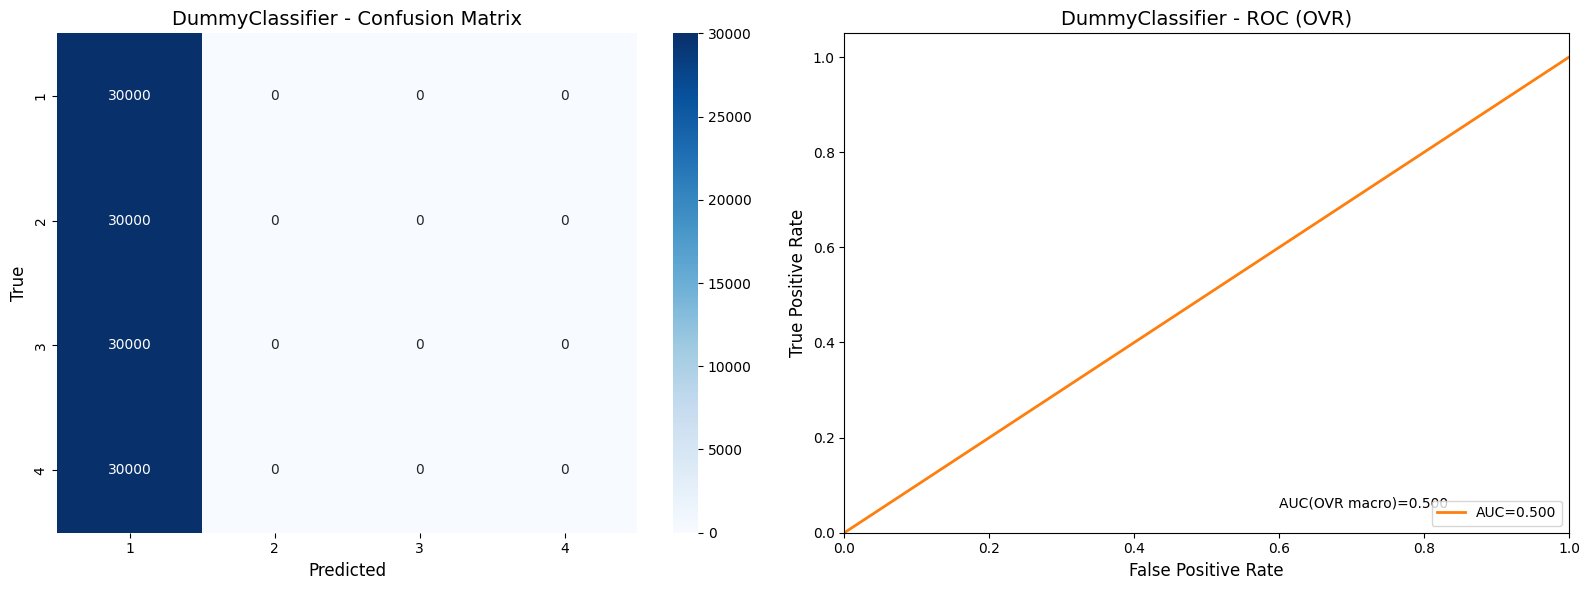

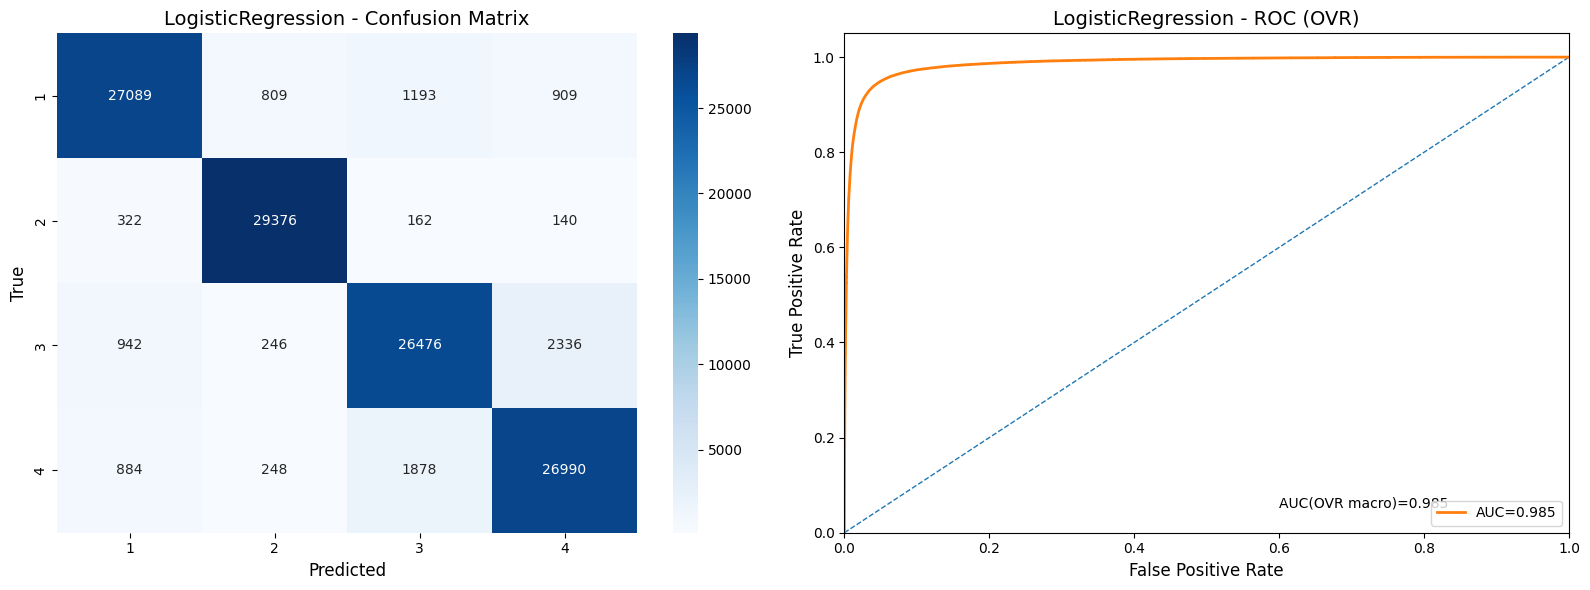

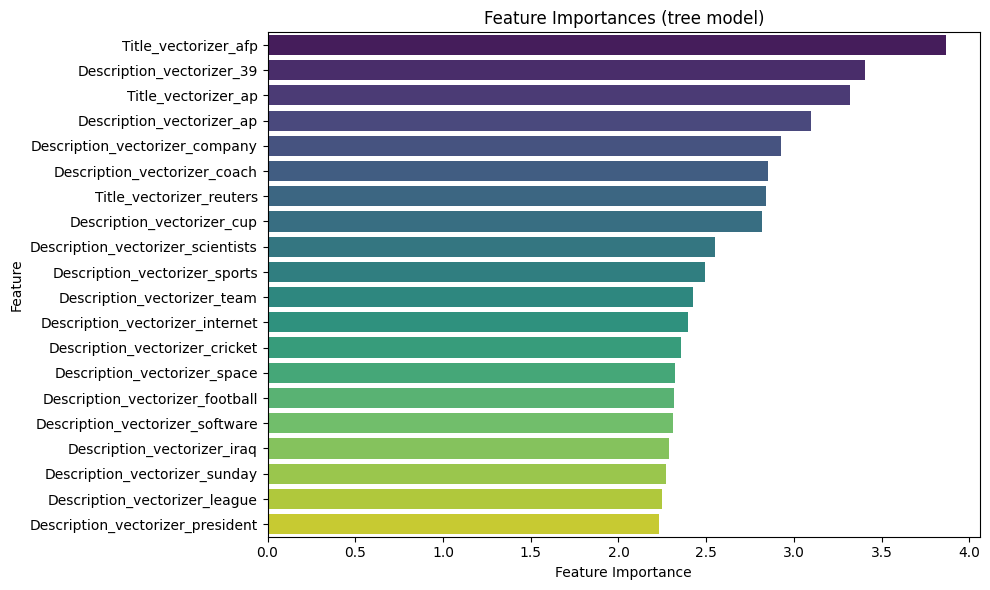

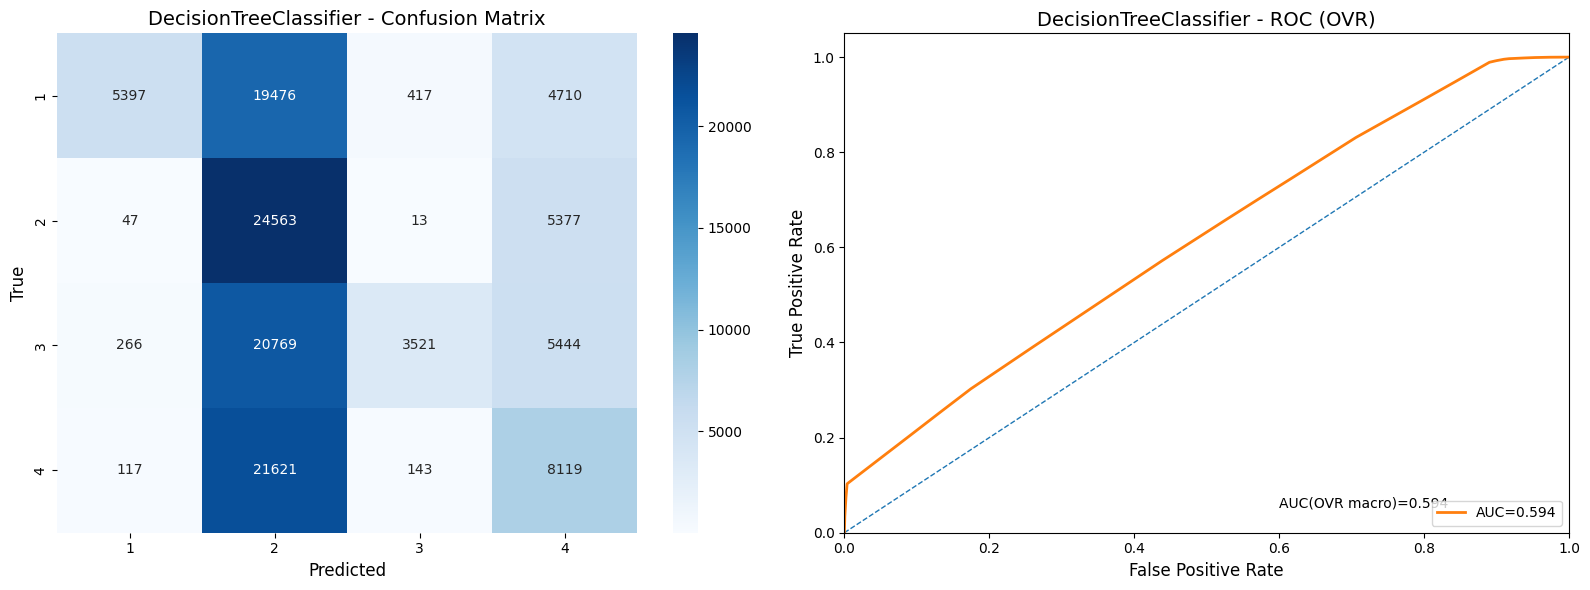

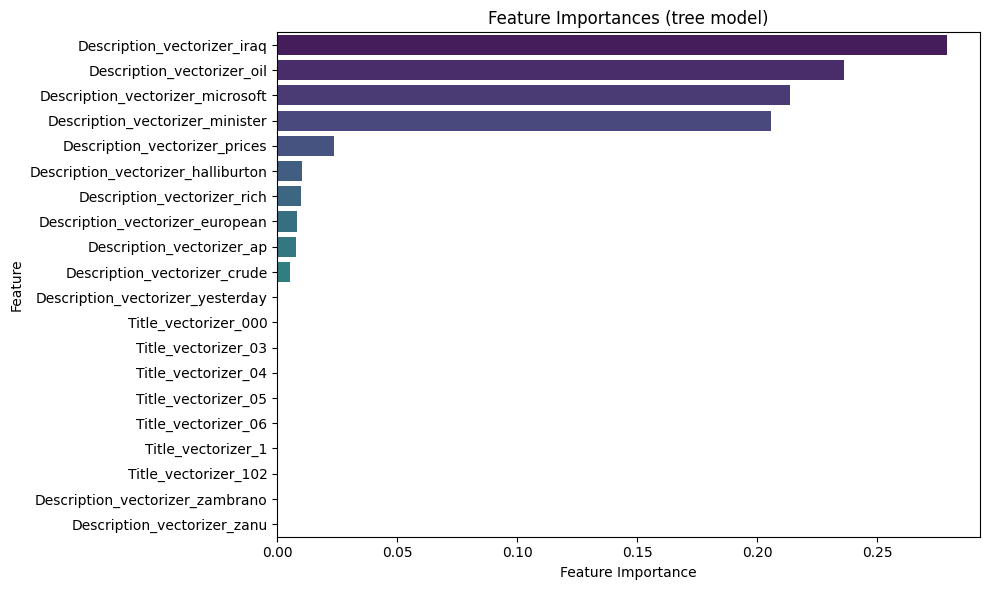

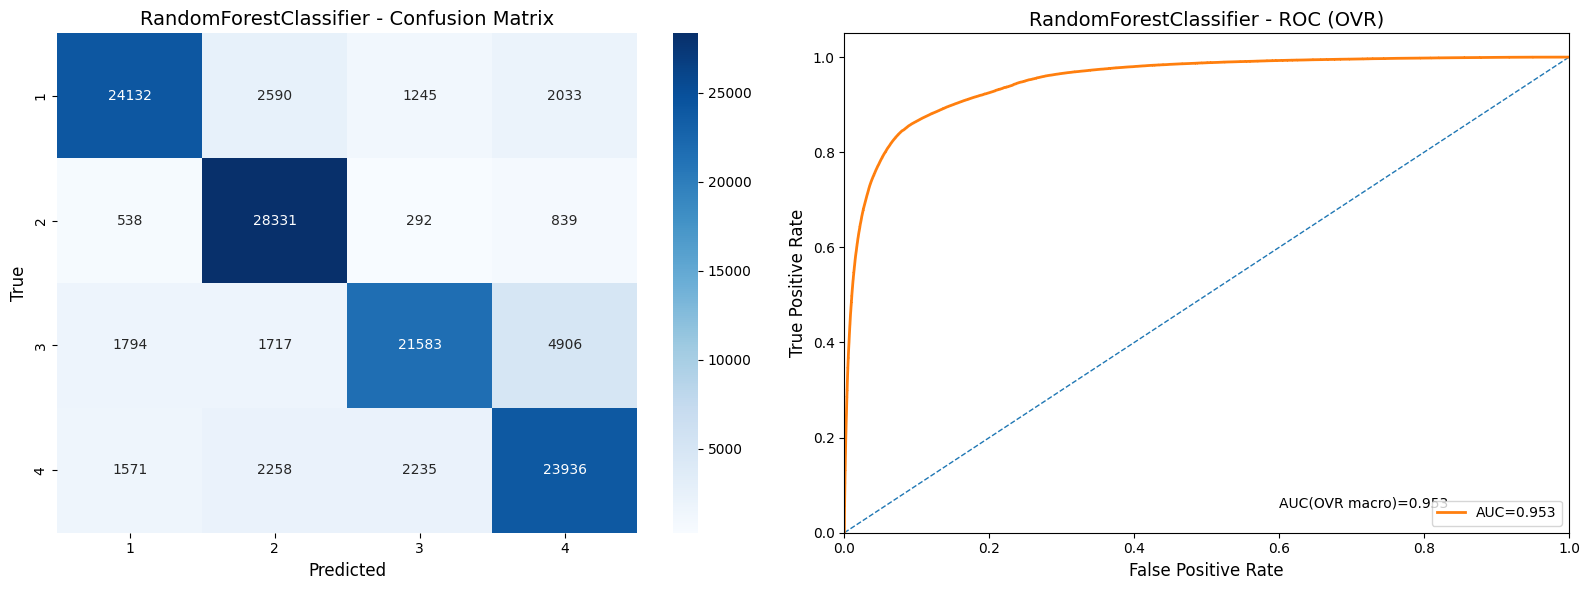

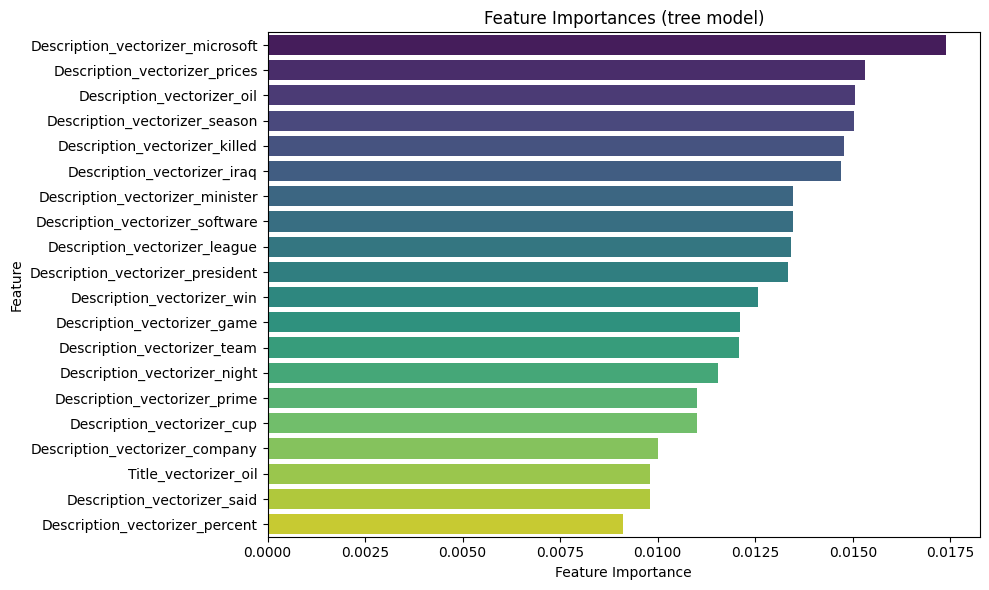

c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Nocomp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:26

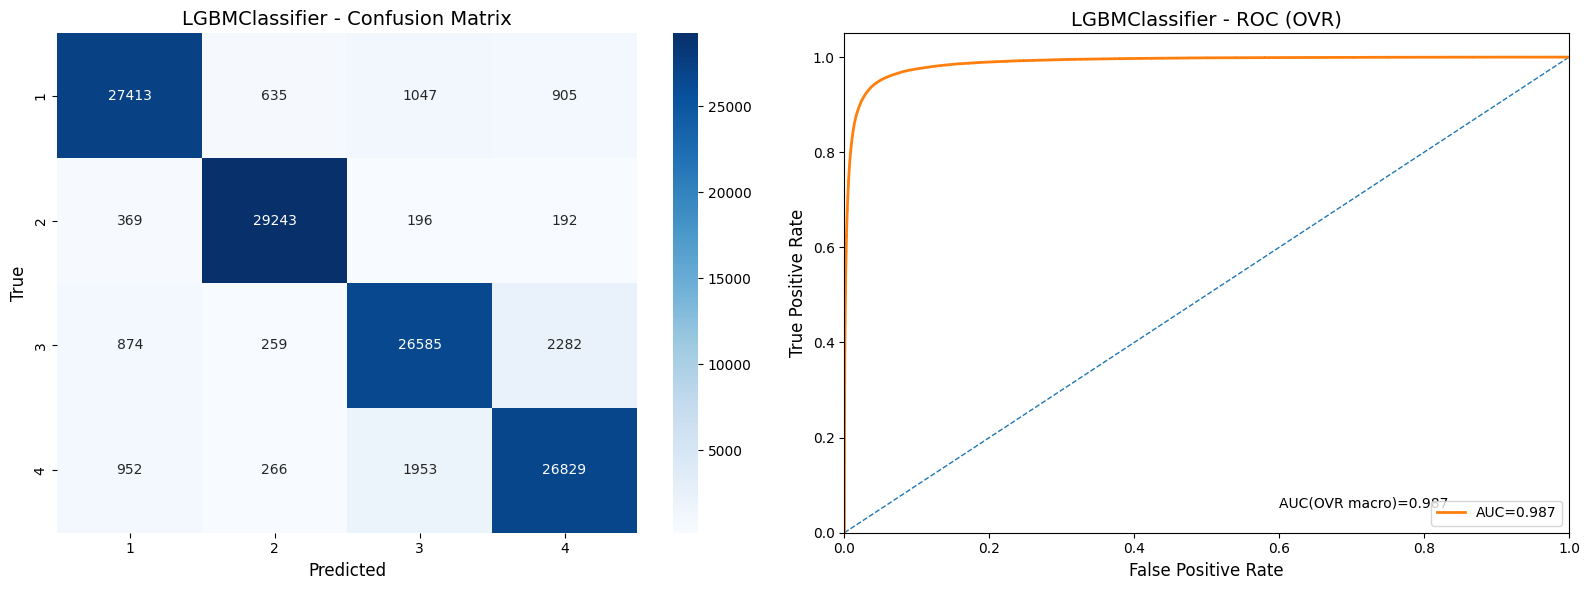

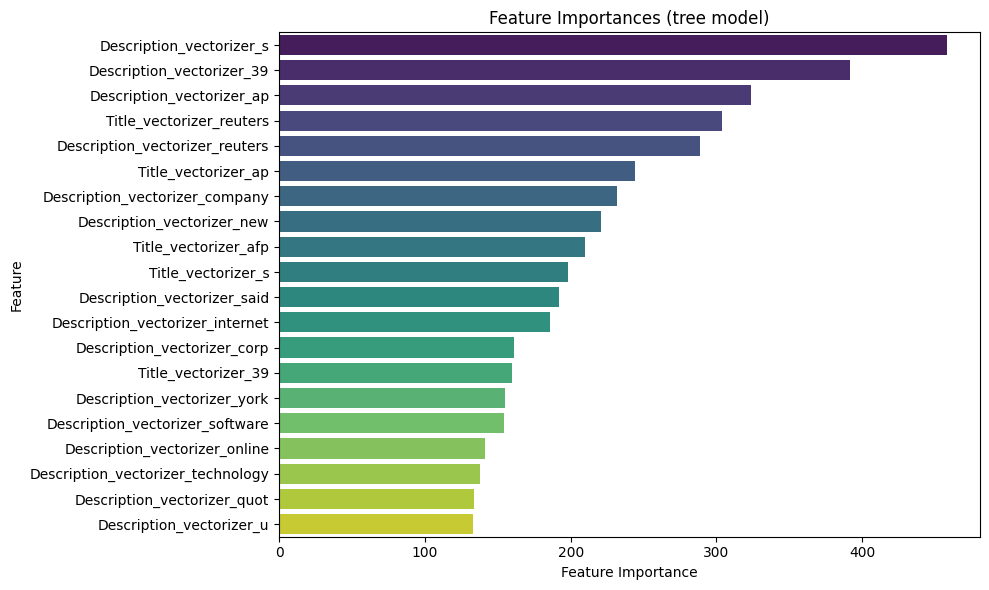

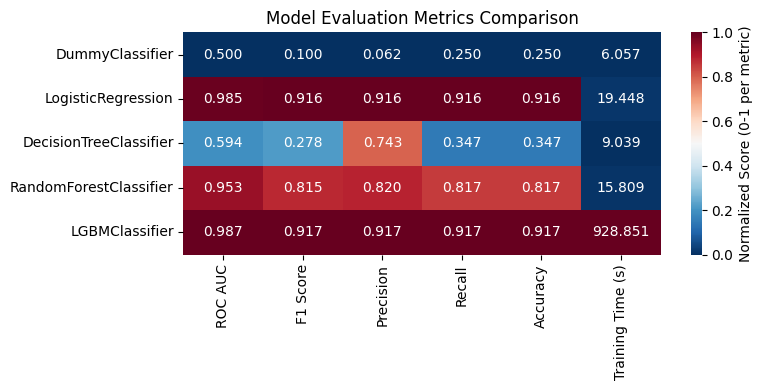

In [26]:
# Обучаем TF-IDF модели на данных без стоп-слов
tfidf_vectorizer_clean_metrics = train_evaluate_models_cv(
    models=models,
    X=X_cleaned_tokens,
    y=y,
    preprocessor=tfidf_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
     ROC AUC  F1 Score  Precision    Recall  Accuracy  Training Time (s)
 0  0.000000  0.000000   0.000000  0.000000  0.000000          -0.241583
 1  0.004022  0.021505   0.021565  0.021558  0.021558           3.191822
 2  0.000131  0.000431   0.002335 -0.000083 -0.000083           1.732520
 3  0.005781  0.017134   0.015080  0.018567  0.018567           2.833903
 4 -0.000048 -0.000176  -0.000190 -0.000175 -0.000175         843.493132)

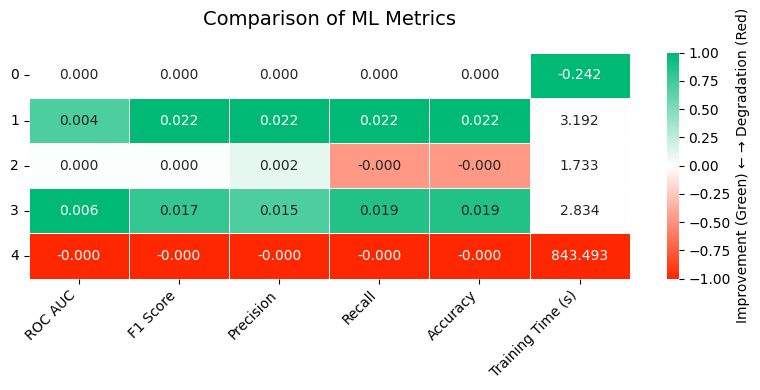

In [27]:
# Сравниваем CountVectorizer и TfidfVectorizer на очищенных данных
compare_metrics_heatmap(count_vectorizer_cleaned_metrics, tfidf_vectorizer_clean_metrics)

**вывод:**

TF-IDF на очищенных токенах даёт небольшой прирост метрик для LogisticRegression и RandomForest. Для DecisionTree эффект нулевой. Для бустинга (LGBM) улучшения нет — метрики остаются на том же уровне или чуть хуже (разница близка к нулю, но в минус).

Проблемы:
- Время обучения резко выросло, особенно на LGBM (самый большой вклад в “удорожание” эксперимента).
- Прирост качества малый и проявляется не у всех моделей.

Рекомендация:
Использовать TF-IDF на очищенных данных имеет смысл, если целевые модели — линейная и/или лес. Если в фокусе LGBM, то TF-IDF в текущей конфигурации не оправдан: качества не добавляет, а обучение сильно замедляет.

### 7. Выводы по baseline моделям

**Лучший результат:** CountVectorizer с удалением стоп-слов метрики особо не меняет, но уменьшает время обучения.

**Ключевые находки:**
1. **Отбор важных токенов:** Помогает только линейным моделям, но замедляет обучение

### План дальнейшего развития

**Улучшения предобработки:**
- убрать стоп-слова и пунктуацию

**Классические подходы к векторизации:**
- Count vectorizer (частота вхождения каждого токена в текст) ✅
- HashingVectorizer

**Нейросетевые подходы:**
- кастомная нейронка (RNN)
- кастомная нейронка (LSTM) 
- кастомная нейронка (CNN)
- pre-trained эмбеддинги для слов (GloVe и другие)
- предобученные модели с классификацией (transformers, BERT)

**Гибридные подходы:**
- эмбеддинги из обученных ранее моделей
- эмбеддинги из предобученных моделей (transformers, BERT)
- OpenAI эмбеддинги (и другие LLM)

**Улучшения токенизации:**
- другие более умные токенизаторы
- учет domain specific слов
- удаление стоп-слов и знаков препинания
- оставить только топ-x токенов по метрике
- удалить токены с высокой корреляцией